## E-Bike Survey Machine Learning Modelling 


See the Data Exploration notebook for how the data was pre-processed.

Because of the highly categorical nature of the data, **tree-based models** are an obvious first choice. 

We will attempt to predict 'Yes' or 'No' to the question: “Does your household have access to any of the following types of private motorized vehicles?”

In [584]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os, sys, gc
import glob
import datetime

color = sns.color_palette()

from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

%matplotlib inline

In [585]:
pd.set_option('max_colwidth', 130)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)

Read the data back in.

In [586]:
df_pred = pd.read_csv('ebike_pred.csv', parse_dates=['Timestamp'], index_col=0)
df_pred_dummies = pd.read_csv('ebike_pred_OHE.csv', parse_dates=['Timestamp'], index_col=0)
df_label = pd.read_csv('ebike_label.csv', header=None, index_col=0)

## A Bit More Pre-processing

A few more minor tweaks to our dataset.

Convert the datetime to the integer scale accordingly for model (can be converted back with `pd.to_datetime`. 

In [587]:
df_pred['Timestamp'] = pd.to_numeric(df_pred['Timestamp'])/1e10
df_pred_dummies['Timestamp'] = pd.to_numeric(df_pred_dummies['Timestamp'])/1e10

Cast values from float64 to float32 for model.

In [588]:
df_pred_dummies[['Timestamp', 'What age range do you fall in?']] = df_pred_dummies[['Timestamp', 'What age range do you fall in?']].astype('float32')

Fill NaN values in 'What age range do you fall in?' with the median.

In [589]:
df_pred_dummies.loc[df_pred_dummies['What age range do you fall in?'].isnull(), 'What age range do you fall in?']

782    NaN
845    NaN
868    NaN
1931   NaN
Name: What age range do you fall in?, dtype: float32

In [590]:
df_pred_dummies['What age range do you fall in?'].median()

3.0

In [591]:
df_pred_dummies['What age range do you fall in?'].fillna(3.0, inplace=True)

### Note

Our data is about 75% **Yes** and 25% **No**, and therefore we have to be quite careful with our models and look at additional metrics, such as precision, recall, f1-score, etc.

In [592]:
df_label[1].value_counts()

1    1716
0     522
Name: 1, dtype: int64

In [593]:
from sklearn.preprocessing import LabelEncoder

In [594]:
pd.factorize(df_pred['What age range do you fall in?'])

(array([0, 1, 2, ..., 2, 0, 1]),
 Index(['35 to 49', '18 to 34', '50 to 64', '17 or younger',
        '65 years or more'],
       dtype='object'))

### Label Encoding

Here we do normal label encoding, in addition to One-Hot Encoding.

In [595]:
#%%time
le = LabelEncoder()
ref = {} #Reference to what label meant what

var_to_encode = list(df_pred.columns)
var_to_encode.remove('Timestamp')
for col in var_to_encode:
    df_pred[col], ref[col] = pd.factorize(df_pred[col])
    
    #ref records these label encoders
    #ref[col] = dict(zip(df_pred[col].unique(), le.transform(df_pred[col].unique())))
    
#How many labels are there?
# -1 is NaN 
for col in var_to_encode:
    print('Unique labels for', col, ': ', df_pred[col].unique())
    print('There are this many unique labels: ', len(df_pred[col].unique()), '\n')

Unique labels for What age range do you fall in? :  [ 0  1  2  3  4 -1]
There are this many unique labels:  6 

Unique labels for Sex :  [ 0  1  2 -1]
There are this many unique labels:  4 

Unique labels for How would you describe your level of physical health? :  [ 0  1  2  3  4 -1  5]
There are this many unique labels:  7 

Unique labels for What level of education have you reached? :  [ 0  1  2  3  4 -1]
There are this many unique labels:  6 

Unique labels for What is your household income? :  [ 0  1  2  3  4  5 -1]
There are this many unique labels:  7 

Unique labels for Which category best describes your employment? :  [ 0  1  2  3  4  5  6  7 -1]
There are this many unique labels:  9 

Unique labels for What Toronto district is your primary address located in? :  [ 0  1  2  3  4  5  6 -1]
There are this many unique labels:  8 

Unique labels for On average what distance do you travel most days of the week? :  [ 0  1  2  3  4 -1]
There are this many unique labels:  6 

Unique l

In [596]:
df_pred.head()

,Timestamp,What age range do you fall in?,Sex,How would you describe your level of physical health?,What level of education have you reached?,What is your household income?,Which category best describes your employment?,What Toronto district is your primary address located in?,On average what distance do you travel most days of the week?,On average how long is your commute?,Which transportation option do you end up using most often?,When you use Toronto's Multi-Use Trails do you mostly,Are you aware that the Multi-Use Paths have a speed limit of 20 km/h?,Have you witnessed a collision or conflict on a trail between,Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit?,Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only and those propelled by motor power may be fined,When you use Toronto's bicycle lanes do you mostly,Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined,With regards to illegal use of bicycles and e-bikes on sidewalks should the City,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City
0,136559580.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,136559700.0,1,0,1,1,1,1,0,1,1,0,1,0,1,0,1,0,1,1,1
2,136559718.0,2,0,0,1,1,0,0,1,0,1,2,0,1,1,1,1,2,0,2
3,136559832.0,2,0,0,2,2,0,0,0,0,2,3,0,2,1,2,2,3,2,3
4,136560024.0,1,0,2,3,1,0,0,2,0,2,2,0,1,0,2,1,3,3,3


## Train-Test Split

In [597]:
from sklearn.model_selection import train_test_split

In [598]:
seed = 42

X_train, X_test, y_train, y_test = train_test_split(df_pred, df_label, test_size=0.3, random_state=seed)
X_train_OHE, X_test_OHE, _ , _ = train_test_split(df_pred_dummies, df_label, test_size=0.3, random_state=seed)

## Random Forest 

Here we will begin with a classic ensemble CART method, Random Forest.

In [599]:
from sklearn.ensemble import RandomForestClassifier

In [600]:
%%time
RF = RandomForestClassifier(n_estimators = 200, max_depth=15, max_features='auto')

RF.fit(X_train, y_train)

/home/dluo/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 1.35 s, sys: 4 ms, total: 1.36 s
Wall time: 1.38 s


In [601]:
print('Baseline Train Score (Yes Prediction): {:0.4f}'.format(accuracy_score(y_train, np.ones(len(X_train)))))
print('Baseline Test Score (Yes Prediction): {:0.4f}\n'.format(accuracy_score(y_test, np.ones(len(X_test)))))
print("\n---- Baseline Classification Report ---\n")
print(classification_report(y_test, np.ones(len(X_test)), target_names=['No', 'Yes']))
print('Train Accuracy: {:0.4f}'.format(RF.score(X_train, y_train)))
print('Test Accuracy: {:0.4f}\n'.format(RF.score(X_test, y_test)))
print("\n---- Train Confusion Matrix ---\n")
print(confusion_matrix(y_train, RF.predict(X_train)))
print("\n---- Test Confusion Matrix ---\n")
print(confusion_matrix(y_test, RF.predict(X_test)))
print("\n---- Classification Report ---\n")
print(classification_report(y_test, RF.predict(X_test), target_names=['No', 'Yes']))

Baseline Train Score (Yes Prediction): 0.7580
Baseline Test Score (Yes Prediction): 0.7872


---- Baseline Classification Report ---

             precision    recall  f1-score   support

         No       0.00      0.00      0.00       143
        Yes       0.79      1.00      0.88       529

avg / total       0.62      0.79      0.69       672

Train Accuracy: 1.0000


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Accuracy: 0.8125


---- Train Confusion Matrix ---

[[ 379    0]
 [   0 1187]]

---- Test Confusion Matrix ---

[[ 58  85]
 [ 41 488]]

---- Classification Report ---

             precision    recall  f1-score   support

         No       0.59      0.41      0.48       143
        Yes       0.85      0.92      0.89       529

avg / total       0.80      0.81      0.80       672



### Visualization

We makes some visualizations of our initial Random Forest model.

<Container object of 20 artists>

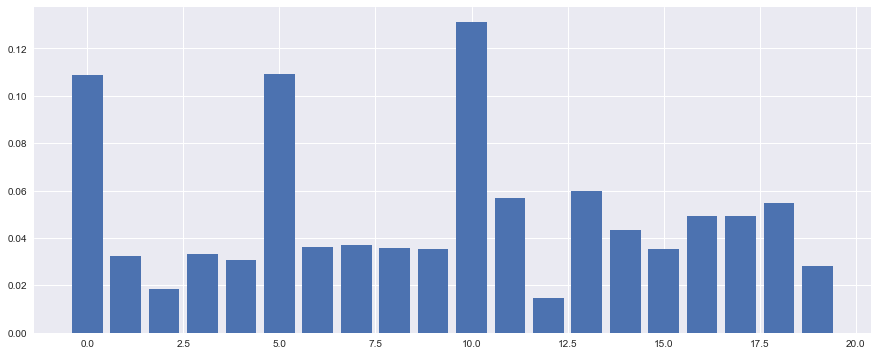

In [602]:
fi = RF.feature_importances_

plt.figure(figsize=(15, 6))
plt.bar(range(len(fi)), fi)
#plt.xticks(range(len(fi)), rotation=60)

In [603]:
# Column importance

fi_df = pd.DataFrame({'Column': X_test.columns[fi.argsort()[::-1]], 'Feature Importance': np.sort(fi)[::-1]})
fi_df

,Column,Feature Importance
0,Which transportation option do you end up using most often?,0.131112
1,What is your household income?,0.109067
2,Timestamp,0.108885
3,Have you witnessed a collision or conflict on a trail between,0.059908
4,When you use Toronto's Multi-Use Trails do you mostly,0.056876
5,With regards to illegal use of bicycles and e-bikes on sidewalks should the City,0.054956
6,When you use Toronto's bicycle lanes do you mostly,0.049129
7,Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power ...,0.049122
8,Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit?,0.043591
9,What Toronto district is your primary address located in?,0.036953


### Hyperparameter Optimization

Due to the small size of the data, and the quickness of the training, we may do Grid Search to optimize hyperparameters.

In [604]:
from sklearn.model_selection import GridSearchCV

In [605]:
params = {'n_estimators':  [50, 100, 200],
                    'max_features': ['sqrt', 'auto'],
                    'max_depth': [10, 20, 30]
                     }

In [606]:
%%time
#Each model trains pretty fast, don't specify n_jobs at model level, specify at grid-search level
RF_GS = GridSearchCV(RandomForestClassifier(), params, verbose=2, n_jobs=4)
RF_GS.fit(X_train, y_train.values.reshape(len(y_train)))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=10, n_estimators=50, max_features=sqrt ................
[CV] max_depth=10, n_estimators=50, max_features=sqrt ................
[CV] max_depth=10, n_estimators=50, max_features=sqrt ................
[CV] max_depth=10, n_estimators=100, max_features=sqrt ...............
[CV] . max_depth=10, n_estimators=50, max_features=sqrt, total=   0.5s
[CV] max_depth=10, n_estimators=100, max_features=sqrt ...............
[CV] . max_depth=10, n_estimators=50, max_features=sqrt, total=   0.6s
[CV] max_depth=10, n_estimators=100, max_features=sqrt ...............
[CV] . max_depth=10, n_estimators=50, max_features=sqrt, total=   0.6s
[CV] max_depth=10, n_estimators=200, max_features=sqrt ...............
[CV]  max_depth=10, n_estimators=100, max_features=sqrt, total=   1.0s
[CV] max_depth=10, n_estimators=200, max_features=sqrt ...............
[CV]  max_depth=10, n_estimators=100, max_features=sqrt, total=   0.9s
[CV] max_depth=1

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.7s


[CV] . max_depth=30, n_estimators=50, max_features=sqrt, total=   0.7s
[CV] max_depth=30, n_estimators=50, max_features=sqrt ................
[CV]  max_depth=20, n_estimators=200, max_features=auto, total=   1.5s
[CV] max_depth=30, n_estimators=50, max_features=sqrt ................
[CV] . max_depth=30, n_estimators=50, max_features=sqrt, total=   0.4s
[CV] max_depth=30, n_estimators=100, max_features=sqrt ...............
[CV] . max_depth=30, n_estimators=50, max_features=sqrt, total=   0.4s
[CV] max_depth=30, n_estimators=100, max_features=sqrt ...............
[CV]  max_depth=20, n_estimators=200, max_features=auto, total=   1.6s
[CV] max_depth=30, n_estimators=100, max_features=sqrt ...............
[CV]  max_depth=20, n_estimators=200, max_features=auto, total=   1.7s
[CV] max_depth=30, n_estimators=200, max_features=sqrt ...............
[CV]  max_depth=30, n_estimators=100, max_features=sqrt, total=   0.9s
[CV] max_depth=30, n_estimators=200, max_features=sqrt ...............
[CV]  

[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:   15.7s finished


CPU times: user 1.22 s, sys: 148 ms, total: 1.36 s
Wall time: 16.8 s


In [607]:
hyper_df = pd.DataFrame(RF_GS.cv_results_)
display(hyper_df.sort_values('rank_test_score'))

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
16,0.759696,0.061924,0.792465,1.000000,30,auto,100,"{'n_estimators': 100, 'max_depth': 30, 'max_features': 'auto'}",1,0.816444,1.000000,0.791188,1.000000,0.769674,1.000000,0.019130,0.006861,0.019115,0.000000
14,1.445967,0.101769,0.788633,1.000000,30,sqrt,200,"{'n_estimators': 200, 'max_depth': 30, 'max_features': 'sqrt'}",2,0.816444,1.000000,0.785441,1.000000,0.763916,1.000000,0.053476,0.005416,0.021563,0.000000
15,0.401900,0.030635,0.786718,0.999681,30,auto,50,"{'n_estimators': 50, 'max_depth': 30, 'max_features': 'auto'}",3,0.806883,1.000000,0.791188,0.999042,0.761996,1.000000,0.042353,0.004341,0.018596,0.000452
8,1.803829,0.124033,0.786079,1.000000,20,sqrt,200,"{'n_estimators': 200, 'max_depth': 20, 'max_features': 'sqrt'}",4,0.806883,1.000000,0.789272,1.000000,0.761996,1.000000,0.195065,0.025240,0.018464,0.000000
17,1.235669,0.077413,0.786079,1.000000,30,auto,200,"{'n_estimators': 200, 'max_depth': 30, 'max_features': 'auto'}",4,0.812620,1.000000,0.783525,1.000000,0.761996,1.000000,0.117036,0.010376,0.020746,0.000000
1,0.857242,0.062407,0.784802,0.974452,10,sqrt,100,"{'n_estimators': 100, 'max_depth': 10, 'max_features': 'sqrt'}",6,0.799235,0.965484,0.789272,0.976054,0.765835,0.981818,0.035317,0.016686,0.013997,0.006764
12,0.500777,0.028930,0.784163,0.999680,30,sqrt,50,"{'n_estimators': 50, 'max_depth': 30, 'max_features': 'sqrt'}",7,0.814532,0.999041,0.789272,1.000000,0.748560,1.000000,0.126465,0.005783,0.027174,0.000452
3,0.471992,0.040868,0.782886,0.967426,10,auto,50,"{'n_estimators': 50, 'max_depth': 10, 'max_features': 'auto'}",8,0.801147,0.954938,0.779693,0.969349,0.767754,0.977990,0.038363,0.012439,0.013818,0.009509
11,1.509830,0.099452,0.782886,1.000000,20,auto,200,"{'n_estimators': 200, 'max_depth': 20, 'max_features': 'auto'}",8,0.808795,1.000000,0.791188,1.000000,0.748560,1.000000,0.083394,0.008002,0.025282,0.000000
13,0.757537,0.049385,0.782886,1.000000,30,sqrt,100,"{'n_estimators': 100, 'max_depth': 30, 'max_features': 'sqrt'}",8,0.810707,1.000000,0.785441,1.000000,0.752399,1.000000,0.044428,0.003427,0.023873,0.000000


In [608]:
bestRF = RF_GS.best_estimator_

In [609]:
print('Baseline Train Score (Yes Prediction): {:0.4f}'.format(accuracy_score(y_train, np.ones(len(X_train)))))
print('Baseline Test Score (Yes Prediction): {:0.4f}\n'.format(accuracy_score(y_test, np.ones(len(X_test)))))
print("\n---- Baseline Classification Report ---\n")
print(classification_report(y_test, np.ones(len(X_test)), target_names=['No', 'Yes']))
print('Train Accuracy: {:0.4f}'.format(bestRF.score(X_train, y_train)))
print('Test Accuracy: {:0.4f}\n'.format(bestRF.score(X_test, y_test)))
print("\n---- Train Confusion Matrix ---\n")
print(confusion_matrix(y_train, bestRF.predict(X_train)))
print("\n---- Confusion Matrix ---\n")
print(confusion_matrix(y_test, bestRF.predict(X_test)))
print("\n---- Classification Report ---\n")
print(classification_report(y_test, bestRF.predict(X_test), target_names=['No', 'Yes']))

Baseline Train Score (Yes Prediction): 0.7580
Baseline Test Score (Yes Prediction): 0.7872


---- Baseline Classification Report ---

             precision    recall  f1-score   support

         No       0.00      0.00      0.00       143
        Yes       0.79      1.00      0.88       529

avg / total       0.62      0.79      0.69       672

Train Accuracy: 1.0000
Test Accuracy: 0.8021


---- Train Confusion Matrix ---



/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[ 379    0]
 [   0 1187]]

---- Confusion Matrix ---

[[ 58  85]
 [ 48 481]]

---- Classification Report ---

             precision    recall  f1-score   support

         No       0.55      0.41      0.47       143
        Yes       0.85      0.91      0.88       529

avg / total       0.79      0.80      0.79       672



### One-Hot Encoding Performance

Does OHE labels make it better or worse?

In [610]:
%%time
#Each model trains pretty fast, don't specify n_jobs at model level, specify at grid-search level
RF_OHE_GS = GridSearchCV(RandomForestClassifier(), params, verbose=2, n_jobs=4)
RF_OHE_GS.fit(X_train_OHE, y_train.values.reshape(len(y_train)))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=10, n_estimators=50, max_features=sqrt ................
[CV] max_depth=10, n_estimators=50, max_features=sqrt ................
[CV] max_depth=10, n_estimators=50, max_features=sqrt ................
[CV] max_depth=10, n_estimators=100, max_features=sqrt ...............
[CV] . max_depth=10, n_estimators=50, max_features=sqrt, total=   0.5s
[CV] max_depth=10, n_estimators=100, max_features=sqrt ...............
[CV] . max_depth=10, n_estimators=50, max_features=sqrt, total=   0.5s
[CV] max_depth=10, n_estimators=100, max_features=sqrt ...............
[CV] . max_depth=10, n_estimators=50, max_features=sqrt, total=   0.6s
[CV] max_depth=10, n_estimators=200, max_features=sqrt ...............
[CV]  max_depth=10, n_estimators=100, max_features=sqrt, total=   0.9s
[CV] max_depth=10, n_estimators=200, max_features=sqrt ...............
[CV]  max_depth=10, n_estimators=100, max_features=sqrt, total=   0.9s
[CV] max_depth=1

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.4s


[CV] . max_depth=30, n_estimators=50, max_features=sqrt, total=   0.5s
[CV] max_depth=30, n_estimators=50, max_features=sqrt ................
[CV]  max_depth=20, n_estimators=200, max_features=auto, total=   1.9s
[CV] max_depth=30, n_estimators=50, max_features=sqrt ................
[CV] . max_depth=30, n_estimators=50, max_features=sqrt, total=   0.5s
[CV] max_depth=30, n_estimators=100, max_features=sqrt ...............
[CV] . max_depth=30, n_estimators=50, max_features=sqrt, total=   0.5s
[CV] max_depth=30, n_estimators=100, max_features=sqrt ...............
[CV]  max_depth=20, n_estimators=200, max_features=auto, total=   2.2s
[CV] max_depth=30, n_estimators=100, max_features=sqrt ...............
[CV]  max_depth=20, n_estimators=200, max_features=auto, total=   2.0s
[CV] max_depth=30, n_estimators=200, max_features=sqrt ...............
[CV]  max_depth=30, n_estimators=100, max_features=sqrt, total=   1.1s
[CV] max_depth=30, n_estimators=200, max_features=sqrt ...............
[CV]  

[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:   18.4s finished


CPU times: user 1.65 s, sys: 136 ms, total: 1.78 s
Wall time: 19.3 s


In [611]:
RF_OHE_GS_df = pd.DataFrame(XGB_GS.cv_results_)
display(RF_OHE_GS_df.head())

bestRF_OHE = RF_OHE_GS.best_estimator_

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.034252,0.020775,0.747765,0.942850,0.1,10,10,0.1,"{'n_estimators': 10, 'reg_lambda': 0.1, 'max_depth': 10, 'learning_rate': 0.1}",36,0.774379,0.942474,0.747126,0.951149,0.721689,0.934928,0.134981,0.006552,0.021515,0.006628
1,0.987647,0.021412,0.764368,0.936148,0.1,10,10,1,"{'n_estimators': 10, 'reg_lambda': 1.0, 'max_depth': 10, 'learning_rate': 0.1}",26,0.776291,0.936721,0.777778,0.950192,0.738964,0.921531,0.066918,0.008136,0.017948,0.011708
2,3.304048,0.018064,0.766922,0.988182,0.1,10,40,0.1,"{'n_estimators': 40, 'reg_lambda': 0.1, 'max_depth': 10, 'learning_rate': 0.1}",25,0.782027,0.979866,0.773946,0.989464,0.744722,0.995215,0.545329,0.002400,0.016019,0.006332
3,3.694182,0.021721,0.771392,0.987547,0.1,10,40,1,"{'n_estimators': 40, 'reg_lambda': 1.0, 'max_depth': 10, 'learning_rate': 0.1}",20,0.787763,0.984660,0.791188,0.989464,0.735125,0.988517,0.313797,0.005606,0.025646,0.002078
4,3.592743,0.022818,0.768838,0.989457,0.1,10,80,0.1,"{'n_estimators': 80, 'reg_lambda': 0.1, 'max_depth': 10, 'learning_rate': 0.1}",23,0.782027,0.979866,0.773946,0.989464,0.750480,0.999043,0.949054,0.009042,0.013376,0.007829


In [612]:
print('Baseline Train Score (Yes Prediction): {:0.4f}'.format(accuracy_score(y_train, np.ones(len(X_train_OHE)))))
print('Baseline Test Score (Yes Prediction): {:0.4f}\n'.format(accuracy_score(y_test, np.ones(len(X_test_OHE)))))
print("\n---- Baseline Classification Report ---\n")
print(classification_report(y_test, np.ones(len(X_test_OHE)), target_names=['No', 'Yes']))
print('Train Accuracy: {:0.4f}'.format(bestRF_OHE.score(X_train_OHE, y_train)))
print('Test Accuracy: {:0.4f}\n'.format(bestRF_OHE.score(X_test_OHE, y_test)))
print("\n---- Test Confusion Matrix ---\n")
print(confusion_matrix(y_test, bestRF_OHE.predict(X_test_OHE)))
print("\n---- Test Classification Report ---\n")
print(classification_report(y_test, bestRF_OHE.predict(X_test_OHE), target_names=['No', 'Yes']))

Baseline Train Score (Yes Prediction): 0.7580
Baseline Test Score (Yes Prediction): 0.7872


---- Baseline Classification Report ---

             precision    recall  f1-score   support

         No       0.00      0.00      0.00       143
        Yes       0.79      1.00      0.88       529

avg / total       0.62      0.79      0.69       672

Train Accuracy: 1.0000
Test Accuracy: 0.8051


---- Test Confusion Matrix ---

[[ 51  92]
 [ 39 490]]

---- Test Classification Report ---

             precision    recall  f1-score   support

         No       0.57      0.36      0.44       143
        Yes       0.84      0.93      0.88       529

avg / total       0.78      0.81      0.79       672



/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### One-Hot Encoding Conclusion

OHE does not really make a difference. Decision trees can also learn to categorical variables.

### Visualization

We makes some visualizations of our best Random Forest model.

<Container object of 242 artists>

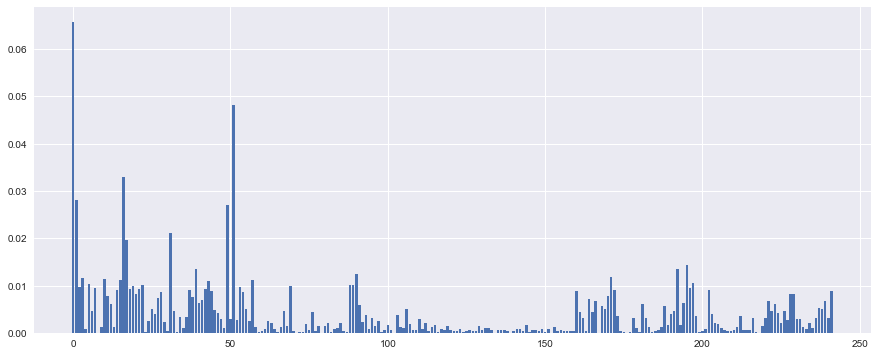

In [613]:
fi = bestRF_OHE.feature_importances_

plt.figure(figsize=(15, 6))
plt.bar(range(len(fi)), fi)
#plt.xticks(range(len(fi)), rotation=60)

Most important column:

In [614]:
X_test_OHE.columns[fi.argmax()]

'Timestamp'

10 most important columns:

In [615]:
fi_df = pd.DataFrame({'Column': X_test_OHE.columns[fi.argsort()[::-1]], 'Feature Importance': np.sort(fi)[::-1]})
fi_df.head(10)

,Column,Feature Importance
0,Timestamp,0.065696
1,Which transportation option do you end up using most often?_private motor vehicle (car truck SUV van motorcycle gas limited sp...,0.048138
2,What is your household income?_$100K+,0.032911
3,What age range do you fall in?,0.028071
4,Which transportation option do you end up using most often?_bicycle,0.027084
5,What Toronto district is your primary address located in?_Central Toronto York or East York,0.021076
6,What is your household income?_$20K to $39K,0.019602
7,When you use Toronto's bicycle lanes do you mostly_ride a road bicycle or a fixie,0.014386
8,On average what distance do you travel most days of the week?_5 - 10 km,0.013450
9,When you use Toronto's bicycle lanes do you mostly_ride a commuter or cruiser style bicycle,0.013394


### Random Forest Conclusion

* With different hyperparameters, the mean test error does not really change.
* Precision and Recall for 'No' are pretty low, especially Recall. We seem to be having trouble with the 'No' answers
* There seems to be something fundamental about our inability to make proper predictions.

## XGBoost

Random Forest did not seem to give us particularly good results, let's try XGBoost to see if it performs better.

In [616]:
#Append path to xgboost, this is a jupyter issue
sys.path.append('/home/dluo/xgboost/python-package')
import xgboost as xgb

In [617]:
%%time
XGB = xgb.XGBClassifier(n_estimators=10, max_depth = 5, learning_rate=.1, n_jobs=4, silent=False)

XGB.fit(X_train_OHE, y_train.values.reshape(len(y_train), 1), eval_set=[(X_test_OHE, y_test)], early_stopping_rounds=20)

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.199405
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.199405
[2]	validation_0-error:0.200893
[3]	validation_0-error:0.181548
[4]	validation_0-error:0.193452
[5]	validation_0-error:0.178571
[6]	validation_0-error:0.18006
[7]	validation_0-error:0.178571
[8]	validation_0-error:0.181548
[9]	validation_0-error:0.183036
CPU times: user 3.12 s, sys: 32 ms, total: 3.16 s
Wall time: 1.52 s


In [618]:
print('Baseline Train Score (Yes Prediction): {:0.4f}'.format(accuracy_score(y_train, np.ones(len(X_train_OHE)))))
print('Baseline Test Score (Yes Prediction): {:0.4f}'.format(accuracy_score(y_test, np.ones(len(X_test_OHE)))))
print("\n---- Baseline Classification Report ---\n")
print(classification_report(y_test, np.ones(len(X_test_OHE)), target_names=['No', 'Yes']))
print('\nTrain Accuracy: {:0.4f}'.format(XGB.score(X_train_OHE, y_train)))
print('Test Accuracy: {:0.4f}'.format(XGB.score(X_test_OHE, y_test)))
print("\n---- Confusion Matrix ---\n")
print(confusion_matrix(y_test, XGB.predict(X_test_OHE)))
print("\n---- Classification Report ---\n")
print(classification_report(y_test, XGB.predict(X_test_OHE), target_names=['No', 'Yes']))

Baseline Train Score (Yes Prediction): 0.7580
Baseline Test Score (Yes Prediction): 0.7872

---- Baseline Classification Report ---

             precision    recall  f1-score   support

         No       0.00      0.00      0.00       143
        Yes       0.79      1.00      0.88       529

avg / total       0.62      0.79      0.69       672


Train Accuracy: 0.8199
Test Accuracy: 0.8170

---- Confusion Matrix ---

[[ 55  88]
 [ 35 494]]

---- Classification Report ---

             precision    recall  f1-score   support

         No       0.61      0.38      0.47       143
        Yes       0.85      0.93      0.89       529

avg / total       0.80      0.82      0.80       672



/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### XGBoost Hyperparameter Optimization

In [619]:
params = {'n_estimators':  [10, 40, 80],
                    'max_depth': [10, 20, 50],
                    'learning_rate': [0.1, 0.5],
                    'reg_lambda': [0.1, 1.],
                     }

In [620]:
%%time
XGB_GS = GridSearchCV(xgb.XGBClassifier(silent=True), params, fit_params={'early_stopping_rounds': 20, 'eval_set':[(X_test_OHE, y_test)]}, verbose=1, n_jobs=4)
XGB_GS.fit(X_train_OHE, y_train.values.reshape(len(y_train)))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.238095
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-error:0.239583
[0]	validation_0-error:0.25744
Will train until validation_0-error hasn't improved in 20 rounds.
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[2]	validation_0-error:0.215774
[1]	validation_0-error:0.251488
[0]	validation_0-error:0.24256
Will train until validation_0-error hasn't improved in 20 rounds.
[3]	validation_0-error:0.212798
[2]	validation_0-error:0.238095
[1]	validation_0-error:0.245536
[1]	validation_0-error:0.239583
[3]	validation_0-error:0.232143
[4]	validation_0-error:0.212798
[2]	validation_0-error:0.233631
[2]	validation_0-error:0.229167
[4]	validation_0-error:0.232143
[5]	validation_0-error:0.212798
[3]	validation_0-error:0.221726
[5]	validation_0-error:0.235119
[3]	validation_0-error:0.224702
[6]	validation_0-error:0.215774
[4]	validation_0-error:0.212798
[4]	validation_0-error:0.224702
[6]	validation_0-error:0.230655
[7]	validation_0-error:0.21875
[5]	validation_0-error:0.227679
[5]	v

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[9]	validation_0-error:0.235119
[9]	validation_0-error:0.199405
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.264881
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.208333
[0]	validation_0-error:0.258929
[1]	validation_0-error:0.235119
[2]	validation_0-error:0.209821
Will train until validation_0-error hasn't improved in 20 rounds.
[0]	validation_0-error:0.238095
Will train until validation_0-error hasn't improved in 20 rounds.
[3]	validation_0-error:0.203869
[2]	validation_0-error:0.220238
[1]	validation_0-error:0.245536
[1]	validation_0-error:0.239583
[4]	validation_0-error:0.19494
[3]	validation_0-error:0.224702
[2]	validation_0-error:0.229167
[2]	validation_0-error:0.215774
[5]	validation_0-error:0.203869
[3]	validation_0-error:0.224702
[3]	validation_0-error:0.212798
[4]	validation_0-error:0.22619
[6]	validation_0-error:0.209821
[4]	validation_0-error:0.212798
[4]	validation_0-error:0.212798
[7]	validation_0-error:0.199405
[5]	validation_0-error:0.232143
[5]	validation_0-error:0.212798
[5]	validation_0-error:0.21131
[8]	v

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[8]	validation_0-error:0.217262
[8]	validation_0-error:0.22619
[7]	validation_0-error:0.203869
[0]	validation_0-error:0.25744
Will train until validation_0-error hasn't improved in 20 rounds.
[9]	validation_0-error:0.206845
[9]	validation_0-error:0.232143
[8]	validation_0-error:0.206845
[10]	validation_0-error:0.206845
[1]	validation_0-error:0.251488


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[9]	validation_0-error:0.199405
[11]	validation_0-error:0.197917
[2]	validation_0-error:0.238095
[10]	validation_0-error:0.205357
[12]	validation_0-error:0.206845
[0]	validation_0-error:0.24256
[3]	validation_0-error:0.232143
[13]	validation_0-error:0.202381
Will train until validation_0-error hasn't improved in 20 rounds.
[11]	validation_0-error:0.205357
[4]	validation_0-error:0.232143
[14]	validation_0-error:0.202381
[1]	validation_0-error:0.239583
[12]	validation_0-error:0.209821
[5]	validation_0-error:0.235119
[15]	validation_0-error:0.199405
[2]	validation_0-error:0.233631
[16]	validation_0-error:0.202381
[13]	validation_0-error:0.206845
[6]	validation_0-error:0.230655
[17]	validation_0-error:0.199405
[3]	validation_0-error:0.221726
[14]	validation_0-error:0.209821
[7]	validation_0-error:0.230655
[18]	validation_0-error:0.203869
[4]	validation_0-error:0.224702
[15]	validation_0-error:0.214286
[19]	validation_0-error:0.212798
[8]	validation_0-error:0.239583
[5]	validation_0-error:0

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Stopping. Best iteration:
[9]	validation_0-error:0.199405

[16]	validation_0-error:0.217262
[22]	validation_0-error:0.232143


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[23]	validation_0-error:0.232143
[17]	validation_0-error:0.224702
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[24]	validation_0-error:0.229167
[18]	validation_0-error:0.21875
[1]	validation_0-error:0.208333
[25]	validation_0-error:0.233631
[19]	validation_0-error:0.214286
[0]	validation_0-error:0.264881
Will train until validation_0-error hasn't improved in 20 rounds.
[2]	validation_0-error:0.209821
[26]	validation_0-error:0.229167
[20]	validation_0-error:0.217262
[1]	validation_0-error:0.235119
[27]	validation_0-error:0.229167
[3]	validation_0-error:0.203869
[21]	validation_0-error:0.220238
[28]	validation_0-error:0.229167
[2]	validation_0-error:0.220238
[22]	validation_0-error:0.214286
[4]	validation_0-error:0.19494
[29]	validation_0-error:0.230655
[23]	validation_0-error:0.21875
[3]	validation_0-error:0.224702
[5]	validation_0-error:0.203869
[30]	validation_0-error:0.233631
[24]	validation_0-error:0.214286
[4]	validation_0-error:

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15]	validation_0-error:0.229167
[35]	validation_0-error:0.220238
[36]	validation_0-error:0.21875
[17]	validation_0-error:0.197917
[16]	validation_0-error:0.224702
[18]	validation_0-error:0.197917
[0]	validation_0-error:0.238095
Will train until validation_0-error hasn't improved in 20 rounds.
[37]	validation_0-error:0.217262
[17]	validation_0-error:0.221726
[1]	validation_0-error:0.239583
[19]	validation_0-error:0.193452
[38]	validation_0-error:0.212798
[18]	validation_0-error:0.217262
[2]	validation_0-error:0.215774
[39]	validation_0-error:0.21131
[20]	validation_0-error:0.191964
[19]	validation_0-error:0.215774
[3]	validation_0-error:0.212798
[21]	validation_0-error:0.196429
[20]	validation_0-error:0.217262
[22]	validation_0-error:0.191964


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-error:0.212798
[21]	validation_0-error:0.215774
[23]	validation_0-error:0.19494
[5]	validation_0-error:0.212798
[22]	validation_0-error:0.217262
[0]	validation_0-error:0.258929
[6]	validation_0-error:0.215774
[24]	validation_0-error:0.19494
Will train until validation_0-error hasn't improved in 20 rounds.
[23]	validation_0-error:0.21131
[7]	validation_0-error:0.21875
[1]	validation_0-error:0.245536
[25]	validation_0-error:0.193452
[8]	validation_0-error:0.217262
[24]	validation_0-error:0.215774
[26]	validation_0-error:0.19494
[2]	validation_0-error:0.229167
[9]	validation_0-error:0.206845
[3]	validation_0-error:0.224702
[25]	validation_0-error:0.217262
[27]	validation_0-error:0.19494
[10]	validation_0-error:0.206845
[4]	validation_0-error:0.212798
[28]	validation_0-error:0.193452
[26]	validation_0-error:0.217262
[5]	validation_0-error:0.21131
[11]	validation_0-error:0.197917
[6]	validation_0-error:0.203869
[29]	validation_0-error:0.19494
[27]	validation_0-error:0.20982

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[13]	validation_0-error:0.206845
[32]	validation_0-error:0.21131
[17]	validation_0-error:0.199405
[14]	validation_0-error:0.209821
[33]	validation_0-error:0.209821
[18]	validation_0-error:0.203869
[0]	validation_0-error:0.25744
[15]	validation_0-error:0.214286
Will train until validation_0-error hasn't improved in 20 rounds.
[34]	validation_0-error:0.206845
[19]	validation_0-error:0.212798
[16]	validation_0-error:0.209821
[1]	validation_0-error:0.251488
[35]	validation_0-error:0.205357
[17]	validation_0-error:0.203869
[36]	validation_0-error:0.205357
[20]	validation_0-error:0.212798
[18]	validation_0-error:0.206845
[2]	validation_0-error:0.238095
[21]	validation_0-error:0.217262
[37]	validation_0-error:0.203869
[19]	validation_0-error:0.202381
[22]	validation_0-error:0.217262
[38]	validation_0-error:0.208333
[3]	validation_0-error:0.232143
[20]	validation_0-error:0.203869
[4]	validation_0-error:0.232143
[39]	validation_0-error:0.209821
[23]	validation_0-error:0.220238
[24]	validation_0

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-error:0.235119
[25]	validation_0-error:0.224702
[22]	validation_0-error:0.202381
[6]	validation_0-error:0.230655
[26]	validation_0-error:0.227679
[0]	validation_0-error:0.24256
Will train until validation_0-error hasn't improved in 20 rounds.
[7]	validation_0-error:0.230655
[23]	validation_0-error:0.208333
[27]	validation_0-error:0.229167
[24]	validation_0-error:0.205357
[1]	validation_0-error:0.239583
[28]	validation_0-error:0.227679
[8]	validation_0-error:0.239583
[2]	validation_0-error:0.233631
[25]	validation_0-error:0.205357
[29]	validation_0-error:0.223214
[9]	validation_0-error:0.235119
[30]	validation_0-error:0.221726
[3]	validation_0-error:0.221726
[26]	validation_0-error:0.203869
[10]	validation_0-error:0.239583
[4]	validation_0-error:0.224702
[31]	validation_0-error:0.220238
Stopping. Best iteration:
[11]	validation_0-error:0.197917

[27]	validation_0-error:0.208333
[11]	validation_0-error:0.238095
[5]	validation_0-error:0.227679


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12]	validation_0-error:0.245536
[28]	validation_0-error:0.208333
[6]	validation_0-error:0.236607
[29]	validation_0-error:0.21131
[13]	validation_0-error:0.239583
Stopping. Best iteration:
[9]	validation_0-error:0.199405

[7]	validation_0-error:0.235119
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[14]	validation_0-error:0.238095
[8]	validation_0-error:0.238095


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15]	validation_0-error:0.235119
[9]	validation_0-error:0.235119
[16]	validation_0-error:0.232143
[1]	validation_0-error:0.208333
[10]	validation_0-error:0.233631
[0]	validation_0-error:0.264881
Will train until validation_0-error hasn't improved in 20 rounds.
[17]	validation_0-error:0.232143
[11]	validation_0-error:0.227679
[2]	validation_0-error:0.209821
[18]	validation_0-error:0.233631
[1]	validation_0-error:0.235119
[12]	validation_0-error:0.221726
[3]	validation_0-error:0.203869
[19]	validation_0-error:0.236607
[2]	validation_0-error:0.220238
[4]	validation_0-error:0.19494
[13]	validation_0-error:0.224702
[5]	validation_0-error:0.203869
[3]	validation_0-error:0.224702
[20]	validation_0-error:0.229167
[14]	validation_0-error:0.223214
[6]	validation_0-error:0.209821
[21]	validation_0-error:0.232143
[15]	validation_0-error:0.221726
[4]	validation_0-error:0.22619
[7]	validation_0-error:0.199405
[22]	validation_0-error:0.232143
[16]	validation_0-error:0.217262
[5]	validation_0-error:0.

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[35]	validation_0-error:0.205357
[45]	validation_0-error:0.209821
[46]	validation_0-error:0.206845
[51]	validation_0-error:0.224702
[36]	validation_0-error:0.205357
[47]	validation_0-error:0.206845
[52]	validation_0-error:0.223214
Stopping. Best iteration:
[32]	validation_0-error:0.220238

[37]	validation_0-error:0.203869
[0]	validation_0-error:0.245536
[48]	validation_0-error:0.208333
Will train until validation_0-error hasn't improved in 20 rounds.
[38]	validation_0-error:0.208333


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-error:0.260417
[49]	validation_0-error:0.214286
[39]	validation_0-error:0.209821
[2]	validation_0-error:0.227679
[50]	validation_0-error:0.212798
[40]	validation_0-error:0.203869
Stopping. Best iteration:
[30]	validation_0-error:0.206845

[0]	validation_0-error:0.270833
Will train until validation_0-error hasn't improved in 20 rounds.
[41]	validation_0-error:0.209821


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-error:0.212798
[42]	validation_0-error:0.203869
[1]	validation_0-error:0.247024
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[43]	validation_0-error:0.208333
[4]	validation_0-error:0.229167
[2]	validation_0-error:0.247024
[44]	validation_0-error:0.214286
[5]	validation_0-error:0.223214
[45]	validation_0-error:0.21131
[3]	validation_0-error:0.233631
[1]	validation_0-error:0.244048
[46]	validation_0-error:0.209821
[6]	validation_0-error:0.22619
[2]	validation_0-error:0.251488
[4]	validation_0-error:0.223214
[47]	validation_0-error:0.212798
[5]	validation_0-error:0.221726
[3]	validation_0-error:0.236607
[48]	validation_0-error:0.209821
[7]	validation_0-error:0.215774
[6]	validation_0-error:0.214286
[49]	validation_0-error:0.214286
[4]	validation_0-error:0.235119
[8]	validation_0-error:0.21875
[50]	validation_0-error:0.214286
[7]	validation_0-error:0.215774
[5]	validation_0-error:0.232143
[9]	validation_0-error:0.215774


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[52]	validation_0-error:0.208333
[9]	validation_0-error:0.206845
[7]	validation_0-error:0.232143
[53]	validation_0-error:0.205357
[0]	validation_0-error:0.248512


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Will train until validation_0-error hasn't improved in 20 rounds.
[8]	validation_0-error:0.230655
[54]	validation_0-error:0.209821
[1]	validation_0-error:0.224702
[0]	validation_0-error:0.258929
[9]	validation_0-error:0.224702
[55]	validation_0-error:0.206845
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[56]	validation_0-error:0.214286
[2]	validation_0-error:0.227679
[1]	validation_0-error:0.22619
[57]	validation_0-error:0.21131
Stopping. Best iteration:
[37]	validation_0-error:0.203869

[3]	validation_0-error:0.22619
[2]	validation_0-error:0.217262


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[4]	validation_0-error:0.214286
[3]	validation_0-error:0.205357
[1]	validation_0-error:0.235119
[5]	validation_0-error:0.221726
[6]	validation_0-error:0.223214
[4]	validation_0-error:0.202381
[0]	validation_0-error:0.245536
[2]	validation_0-error:0.227679
Will train until validation_0-error hasn't improved in 20 rounds.
[7]	validation_0-error:0.227679
[3]	validation_0-error:0.229167
[4]	validation_0-error:0.21875
[1]	validation_0-error:0.260417
[8]	validation_0-error:0.224702
[5]	validation_0-error:0.196429
[2]	validation_0-error:0.227679
[6]	validation_0-error:0.19494
[5]	validation_0-error:0.22619
[3]	validation_0-error:0.212798
[9]	validation_0-error:0.227679
[6]	validation_0-error:0.22619
[7]	validation_0-error:0.1875
[7]	validation_0-error:0.230655


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-error:0.229167
[8]	validation_0-error:0.200893
[8]	validation_0-error:0.230655
[0]	validation_0-error:0.270833
[5]	validation_0-error:0.223214
Will train until validation_0-error hasn't improved in 20 rounds.
[9]	validation_0-error:0.227679
[9]	validation_0-error:0.203869
[1]	validation_0-error:0.247024


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[6]	validation_0-error:0.22619


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-error:0.247024
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[7]	validation_0-error:0.215774
[3]	validation_0-error:0.233631
[0]	validation_0-error:0.248512
Will train until validation_0-error hasn't improved in 20 rounds.
[8]	validation_0-error:0.21875
[4]	validation_0-error:0.223214
[1]	validation_0-error:0.244048
[2]	validation_0-error:0.251488
[1]	validation_0-error:0.224702
[9]	validation_0-error:0.215774
[5]	validation_0-error:0.221726
[3]	validation_0-error:0.236607
[2]	validation_0-error:0.227679
[10]	validation_0-error:0.217262
[6]	validation_0-error:0.214286
[4]	validation_0-error:0.235119
[3]	validation_0-error:0.22619
[11]	validation_0-error:0.215774
[4]	validation_0-error:0.214286
[7]	validation_0-error:0.215774
[5]	validation_0-error:0.232143
[12]	validation_0-error:0.209821
[5]	validation_0-error:0.221726
[8]	validation_0-error:0.209821
[6]	validation_0-error:0.235119
[13]	validation_0-error:0.208333
[6

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[37]	validation_0-error:0.197917
[39]	validation_0-error:0.217262


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[38]	validation_0-error:0.191964
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[39]	validation_0-error:0.191964
[1]	validation_0-error:0.22619
[0]	validation_0-error:0.245536
[1]	validation_0-error:0.235119
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-error:0.217262
[2]	validation_0-error:0.227679
[1]	validation_0-error:0.260417
[3]	validation_0-error:0.229167
[3]	validation_0-error:0.205357
[2]	validation_0-error:0.227679
[0]	validation_0-error:0.270833
[4]	validation_0-error:0.21875
Will train until validation_0-error hasn't improved in 20 rounds.
[4]	validation_0-error:0.202381
[5]	validation_0-error:0.22619
[1]	validation_0-error:0.247024
[3]	validation_0-error:0.212798
[5]	validation_0-error:0.196429
[2]	validation_0-error:0.247024
[6]	validation_0-error:0.22619
[4]	validation_0-error:0.229167
[6]	validation_0-error:0.19494
[5]	validation_0-error:0.223214
[3]	validation_0-error:0.233631
[7]	validation_0-error:0.230655
[7]	validation_0-error:0.1875
[8]	validation_0-error:0.230655
[6]	validation_0-error:0.22619
[4]	validation_0-error:0.223214
[8]	validation_0-error:0.200893
[9]	validation_0-error:0.227679
[9]	validation_0-error:0.203869
[7]	validation_0-error:0.215774
[5]	validation_0-error:0.221726
[10]	validati

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[39]	validation_0-error:0.19494
[33]	validation_0-error:0.200893
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[32]	validation_0-error:0.203869
[1]	validation_0-error:0.244048
[34]	validation_0-error:0.202381
[33]	validation_0-error:0.199405
[2]	validation_0-error:0.251488
[35]	validation_0-error:0.202381
[0]	validation_0-error:0.248512
[34]	validation_0-error:0.197917
Will train until validation_0-error hasn't improved in 20 rounds.
[3]	validation_0-error:0.236607
[36]	validation_0-error:0.200893
[1]	validation_0-error:0.224702
[37]	validation_0-error:0.203869
[35]	validation_0-error:0.202381
Stopping. Best iteration:
[17]	validation_0-error:0.188988

[4]	validation_0-error:0.235119
[36]	validation_0-error:0.202381
[2]	validation_0-error:0.227679


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-error:0.232143
[37]	validation_0-error:0.205357
[3]	validation_0-error:0.22619
[6]	validation_0-error:0.235119
[4]	validation_0-error:0.214286
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[7]	validation_0-error:0.232143
[38]	validation_0-error:0.202381
[1]	validation_0-error:0.22619
[5]	validation_0-error:0.221726
[8]	validation_0-error:0.230655
[39]	validation_0-error:0.200893
[6]	validation_0-error:0.223214
[2]	validation_0-error:0.217262
[9]	validation_0-error:0.224702
[40]	validation_0-error:0.203869
[7]	validation_0-error:0.227679
[3]	validation_0-error:0.205357
[10]	validation_0-error:0.22619
[8]	validation_0-error:0.224702
[41]	validation_0-error:0.200893
[4]	validation_0-error:0.202381
[11]	validation_0-error:0.22619
[5]	validation_0-error:0.196429
[9]	validation_0-error:0.227679
[42]	validation_0-error:0.19494
[6]	validation_0-error:0.19494
[43]	validation_0-error:0.196429
[12]	validation_0-error:0.227679
[4

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[30]	validation_0-error:0.19494
[35]	validation_0-error:0.220238
[28]	validation_0-error:0.196429
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[31]	validation_0-error:0.193452
[36]	validation_0-error:0.221726
[29]	validation_0-error:0.197917
[1]	validation_0-error:0.235119
[32]	validation_0-error:0.196429
[37]	validation_0-error:0.215774
[30]	validation_0-error:0.196429
[2]	validation_0-error:0.227679
[33]	validation_0-error:0.191964
[38]	validation_0-error:0.215774
[34]	validation_0-error:0.193452
[3]	validation_0-error:0.229167
[31]	validation_0-error:0.193452
[39]	validation_0-error:0.217262
[40]	validation_0-error:0.217262
[35]	validation_0-error:0.199405
[4]	validation_0-error:0.21875
[32]	validation_0-error:0.196429
[41]	validation_0-error:0.220238
[36]	validation_0-error:0.19494
[5]	validation_0-error:0.22619
[33]	validation_0-error:0.197917
[42]	validation_0-error:0.223214
[43]	validation_0-error:0.217262
[37]	validation_0-er

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[7]	validation_0-error:0.230655
[35]	validation_0-error:0.199405
[36]	validation_0-error:0.199405
[8]	validation_0-error:0.230655
[0]	validation_0-error:0.245536
[40]	validation_0-error:0.191964
Will train until validation_0-error hasn't improved in 20 rounds.
[9]	validation_0-error:0.227679
[10]	validation_0-error:0.220238
[37]	validation_0-error:0.196429
[41]	validation_0-error:0.193452
[1]	validation_0-error:0.260417
[11]	validation_0-error:0.227679
[38]	validation_0-error:0.197917
[2]	validation_0-error:0.227679
[42]	validation_0-error:0.193452
[39]	validation_0-error:0.19494
[12]	validation_0-error:0.232143
[3]	validation_0-error:0.212798
[40]	validation_0-error:0.197917
Stopping. Best iteration:
[20]	validation_0-error:0.18006

[43]	validation_0-error:0.193452
[13]	validation_0-error:0.230655
[4]	validation_0-error:0.229167
[44]	validation_0-error:0.190476


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[14]	validation_0-error:0.223214
[45]	validation_0-error:0.193452
[5]	validation_0-error:0.223214
[15]	validation_0-error:0.221726
[0]	validation_0-error:0.270833
Will train until validation_0-error hasn't improved in 20 rounds.
[46]	validation_0-error:0.196429
[6]	validation_0-error:0.22619
[16]	validation_0-error:0.22619
[1]	validation_0-error:0.247024
[7]	validation_0-error:0.215774
[47]	validation_0-error:0.193452
[2]	validation_0-error:0.247024
[8]	validation_0-error:0.21875
[17]	validation_0-error:0.221726
[48]	validation_0-error:0.196429
[49]	validation_0-error:0.193452
[3]	validation_0-error:0.233631
[9]	validation_0-error:0.215774
[18]	validation_0-error:0.221726
[19]	validation_0-error:0.215774
[4]	validation_0-error:0.223214
[50]	validation_0-error:0.193452


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-error:0.221726
[20]	validation_0-error:0.212798
[51]	validation_0-error:0.191964
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[6]	validation_0-error:0.214286
[21]	validation_0-error:0.214286
[22]	validation_0-error:0.214286
[52]	validation_0-error:0.191964
[7]	validation_0-error:0.215774
[1]	validation_0-error:0.244048
[53]	validation_0-error:0.193452
[23]	validation_0-error:0.21131
[2]	validation_0-error:0.251488
[8]	validation_0-error:0.209821
[54]	validation_0-error:0.196429
[3]	validation_0-error:0.236607
[24]	validation_0-error:0.209821
[9]	validation_0-error:0.206845
[4]	validation_0-error:0.235119
[55]	validation_0-error:0.19494


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-error:0.232143
[25]	validation_0-error:0.209821
[56]	validation_0-error:0.196429
[0]	validation_0-error:0.248512
Will train until validation_0-error hasn't improved in 20 rounds.
[6]	validation_0-error:0.235119
[26]	validation_0-error:0.206845
[27]	validation_0-error:0.209821
[1]	validation_0-error:0.224702
[57]	validation_0-error:0.193452
[28]	validation_0-error:0.21131
[7]	validation_0-error:0.232143
[2]	validation_0-error:0.227679
[58]	validation_0-error:0.196429
[8]	validation_0-error:0.230655
[29]	validation_0-error:0.215774
[59]	validation_0-error:0.193452
[3]	validation_0-error:0.22619
[30]	validation_0-error:0.212798
[9]	validation_0-error:0.224702
[60]	validation_0-error:0.19494
[4]	validation_0-error:0.214286
[31]	validation_0-error:0.21131
[61]	validation_0-error:0.196429


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-error:0.221726
[62]	validation_0-error:0.191964
[32]	validation_0-error:0.21131
[6]	validation_0-error:0.223214
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[63]	validation_0-error:0.191964
[33]	validation_0-error:0.212798
[1]	validation_0-error:0.22619
[64]	validation_0-error:0.193452
[7]	validation_0-error:0.227679
Stopping. Best iteration:
[44]	validation_0-error:0.190476

[34]	validation_0-error:0.209821
[2]	validation_0-error:0.217262
[3]	validation_0-error:0.205357
[8]	validation_0-error:0.224702


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-error:0.202381
[35]	validation_0-error:0.209821
[5]	validation_0-error:0.196429
[36]	validation_0-error:0.209821
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[9]	validation_0-error:0.227679
[37]	validation_0-error:0.206845
[6]	validation_0-error:0.19494


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[38]	validation_0-error:0.209821
[1]	validation_0-error:0.235119
[7]	validation_0-error:0.1875
[39]	validation_0-error:0.209821
[2]	validation_0-error:0.227679
[0]	validation_0-error:0.245536
Will train until validation_0-error hasn't improved in 20 rounds.
[8]	validation_0-error:0.200893
[40]	validation_0-error:0.212798
[3]	validation_0-error:0.229167
[9]	validation_0-error:0.203869
[4]	validation_0-error:0.21875
[1]	validation_0-error:0.260417
[41]	validation_0-error:0.214286


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-error:0.22619
[42]	validation_0-error:0.217262
[2]	validation_0-error:0.227679
[6]	validation_0-error:0.22619
[0]	validation_0-error:0.270833
Will train until validation_0-error hasn't improved in 20 rounds.
[43]	validation_0-error:0.217262
[3]	validation_0-error:0.212798
[7]	validation_0-error:0.230655
[1]	validation_0-error:0.247024
[44]	validation_0-error:0.217262
[4]	validation_0-error:0.229167
[2]	validation_0-error:0.247024
[8]	validation_0-error:0.230655
[5]	validation_0-error:0.223214
[45]	validation_0-error:0.21131
[3]	validation_0-error:0.233631
[9]	validation_0-error:0.227679
[46]	validation_0-error:0.209821
Stopping. Best iteration:
[26]	validation_0-error:0.206845

[6]	validation_0-error:0.22619


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-error:0.223214


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[7]	validation_0-error:0.215774
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[5]	validation_0-error:0.221726


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   33.5s


[0]	validation_0-error:0.248512
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.244048
[8]	validation_0-error:0.21875
[6]	validation_0-error:0.214286
[1]	validation_0-error:0.224702
[9]	validation_0-error:0.215774
[2]	validation_0-error:0.251488
[7]	validation_0-error:0.215774
[2]	validation_0-error:0.227679
[3]	validation_0-error:0.236607
[8]	validation_0-error:0.209821
[10]	validation_0-error:0.21875
[4]	validation_0-error:0.235119
[3]	validation_0-error:0.22619
[9]	validation_0-error:0.206845
[11]	validation_0-error:0.215774
[5]	validation_0-error:0.232143
[10]	validation_0-error:0.202381
[4]	validation_0-error:0.214286
[6]	validation_0-error:0.235119
[12]	validation_0-error:0.209821
[11]	validation_0-error:0.208333
[5]	validation_0-error:0.221726
[7]	validation_0-error:0.232143
[8]	validation_0-error:0.230655
[13]	validation_0-error:0.205357
[12]	validation_0-error:0.209821
[6]	validation_0-error:0.223214
[9]	validation_0-error:0.224702
[7

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[35]	validation_0-error:0.200893
[38]	validation_0-error:0.217262
[36]	validation_0-error:0.199405
[38]	validation_0-error:0.21131
[39]	validation_0-error:0.217262
[37]	validation_0-error:0.196429
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[39]	validation_0-error:0.208333


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[38]	validation_0-error:0.199405
[1]	validation_0-error:0.22619


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[39]	validation_0-error:0.200893
[2]	validation_0-error:0.217262
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-error:0.205357
[1]	validation_0-error:0.235119
[0]	validation_0-error:0.245536
Will train until validation_0-error hasn't improved in 20 rounds.
[0]	validation_0-error:0.270833
Will train until validation_0-error hasn't improved in 20 rounds.
[4]	validation_0-error:0.202381
[2]	validation_0-error:0.227679
[1]	validation_0-error:0.260417
[5]	validation_0-error:0.196429
[1]	validation_0-error:0.247024
[3]	validation_0-error:0.229167
[2]	validation_0-error:0.247024
[2]	validation_0-error:0.227679
[6]	validation_0-error:0.19494
[4]	validation_0-error:0.21875
[3]	validation_0-error:0.233631
[7]	validation_0-error:0.1875
[3]	validation_0-error:0.212798
[5]	validation_0-error:0.22619
[8]	validation_0-error:0.200893
[4]	validation_0-error:0.223214
[4]	validation_0-error:0.229167
[6]	validation_0-error:0.22619
[9]	validation_0-error:0.203869
[5]	validation_0-error:0.221726
[7]	validation_0-error:0.230655
[10]	validation_0-error:0.190476
[5]	validation_0-error:0.223214
[6]	valid

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[32]	validation_0-error:0.205357
[37]	validation_0-error:0.206845
[35]	validation_0-error:0.202381
[38]	validation_0-error:0.209821
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[33]	validation_0-error:0.205357
[36]	validation_0-error:0.203869
[39]	validation_0-error:0.209821
[1]	validation_0-error:0.244048
[37]	validation_0-error:0.202381
[34]	validation_0-error:0.200893


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-error:0.251488
[38]	validation_0-error:0.203869
[35]	validation_0-error:0.202381
[0]	validation_0-error:0.248512
[3]	validation_0-error:0.236607
Will train until validation_0-error hasn't improved in 20 rounds.
[36]	validation_0-error:0.202381
[39]	validation_0-error:0.200893
[1]	validation_0-error:0.224702
[4]	validation_0-error:0.235119
[37]	validation_0-error:0.206845
[2]	validation_0-error:0.227679
[40]	validation_0-error:0.202381
[38]	validation_0-error:0.21131
[5]	validation_0-error:0.232143
[41]	validation_0-error:0.203869
[3]	validation_0-error:0.22619
[6]	validation_0-error:0.235119
[39]	validation_0-error:0.208333
[42]	validation_0-error:0.199405
[4]	validation_0-error:0.214286
[40]	validation_0-error:0.208333
[43]	validation_0-error:0.19494
[7]	validation_0-error:0.232143
[5]	validation_0-error:0.221726
[44]	validation_0-error:0.19494
[41]	validation_0-error:0.209821
[8]	validation_0-error:0.230655
[45]	validation_0-error:0.197917
[6]	validation_0-error:0.22

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[32]	validation_0-error:0.21875
[29]	validation_0-error:0.203869
[64]	validation_0-error:0.199405
[33]	validation_0-error:0.220238
[30]	validation_0-error:0.200893
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[65]	validation_0-error:0.200893
[1]	validation_0-error:0.22619
[34]	validation_0-error:0.221726
[31]	validation_0-error:0.203869
[2]	validation_0-error:0.217262
[66]	validation_0-error:0.202381
[3]	validation_0-error:0.205357
[67]	validation_0-error:0.202381
[32]	validation_0-error:0.202381
[35]	validation_0-error:0.217262
[4]	validation_0-error:0.202381
[68]	validation_0-error:0.202381
[36]	validation_0-error:0.215774
[5]	validation_0-error:0.196429
[33]	validation_0-error:0.205357
[69]	validation_0-error:0.200893
[37]	validation_0-error:0.215774
[34]	validation_0-error:0.202381
[6]	validation_0-error:0.19494
[38]	validation_0-error:0.217262
[70]	validation_0-error:0.202381
[39]	validation_0-error:0.217262
[7]	validation_0-err

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[77]	validation_0-error:0.200893
[13]	validation_0-error:0.196429
[40]	validation_0-error:0.200893
[78]	validation_0-error:0.199405
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[79]	validation_0-error:0.202381
[14]	validation_0-error:0.19494
[41]	validation_0-error:0.200893
[1]	validation_0-error:0.235119
[42]	validation_0-error:0.200893


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15]	validation_0-error:0.193452
[43]	validation_0-error:0.200893
[2]	validation_0-error:0.227679
[16]	validation_0-error:0.190476
[0]	validation_0-error:0.238095
Will train until validation_0-error hasn't improved in 20 rounds.
[17]	validation_0-error:0.188988
[3]	validation_0-error:0.229167
[44]	validation_0-error:0.202381
[1]	validation_0-error:0.217262
[18]	validation_0-error:0.188988
[4]	validation_0-error:0.21875
[2]	validation_0-error:0.235119
[19]	validation_0-error:0.183036
[45]	validation_0-error:0.203869
[3]	validation_0-error:0.239583
[5]	validation_0-error:0.22619
[4]	validation_0-error:0.24256
[20]	validation_0-error:0.18006
[46]	validation_0-error:0.200893
[5]	validation_0-error:0.239583
[6]	validation_0-error:0.22619
[21]	validation_0-error:0.1875
[6]	validation_0-error:0.223214
[7]	validation_0-error:0.230655
[47]	validation_0-error:0.199405
[7]	validation_0-error:0.22619
[22]	validation_0-error:0.186012
[8]	validation_0-error:0.230655
[48]	validation_0-error:0.199405


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[24]	validation_0-error:0.196429
[10]	validation_0-error:0.220238
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[50]	validation_0-error:0.200893
[25]	validation_0-error:0.191964
[1]	validation_0-error:0.235119
[11]	validation_0-error:0.227679
[26]	validation_0-error:0.19494
[51]	validation_0-error:0.199405
[2]	validation_0-error:0.22619
[27]	validation_0-error:0.193452
[12]	validation_0-error:0.232143
[3]	validation_0-error:0.205357
[52]	validation_0-error:0.199405
[28]	validation_0-error:0.196429
[13]	validation_0-error:0.230655
[4]	validation_0-error:0.214286
[53]	validation_0-error:0.200893
[14]	validation_0-error:0.223214
[29]	validation_0-error:0.197917
[54]	validation_0-error:0.205357
[5]	validation_0-error:0.21131
[15]	validation_0-error:0.221726
[55]	validation_0-error:0.200893
[30]	validation_0-error:0.196429
[6]	validation_0-error:0.203869
[16]	validation_0-error:0.22619
[31]	validation_0-error:0.193452
[56]	validation_0-err

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[9]	validation_0-error:0.199405
[34]	validation_0-error:0.197917
[19]	validation_0-error:0.215774


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.25744
Will train until validation_0-error hasn't improved in 20 rounds.
[20]	validation_0-error:0.212798
[35]	validation_0-error:0.199405
[0]	validation_0-error:0.24256
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.251488
[21]	validation_0-error:0.214286
[36]	validation_0-error:0.199405
[1]	validation_0-error:0.232143
[2]	validation_0-error:0.235119
[37]	validation_0-error:0.196429
[22]	validation_0-error:0.214286
[3]	validation_0-error:0.22619
[2]	validation_0-error:0.221726
[38]	validation_0-error:0.197917
[4]	validation_0-error:0.224702
[23]	validation_0-error:0.21131
[5]	validation_0-error:0.230655
[3]	validation_0-error:0.21131
[39]	validation_0-error:0.19494
[6]	validation_0-error:0.223214
[4]	validation_0-error:0.220238
[24]	validation_0-error:0.209821
[7]	validation_0-error:0.217262
[40]	validation_0-error:0.197917
Stopping. Best iteration:
[20]	validation_0-error:0.18006

[5]	validation_0-error:0.22619
[8]	v

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[26]	validation_0-error:0.206845


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[7]	validation_0-error:0.223214
[8]	validation_0-error:0.209821
[27]	validation_0-error:0.209821
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[0]	validation_0-error:0.264881
Will train until validation_0-error hasn't improved in 20 rounds.
[9]	validation_0-error:0.208333
[28]	validation_0-error:0.21131
[1]	validation_0-error:0.235119
[1]	validation_0-error:0.239583


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-error:0.217262
[29]	validation_0-error:0.215774
[3]	validation_0-error:0.220238
[0]	validation_0-error:0.238095
[2]	validation_0-error:0.235119
Will train until validation_0-error hasn't improved in 20 rounds.
[30]	validation_0-error:0.212798
[4]	validation_0-error:0.21875
[3]	validation_0-error:0.247024
[1]	validation_0-error:0.217262
[31]	validation_0-error:0.21131
[5]	validation_0-error:0.221726
[4]	validation_0-error:0.229167
[2]	validation_0-error:0.235119
[6]	validation_0-error:0.220238
[32]	validation_0-error:0.21131
[5]	validation_0-error:0.224702
[7]	validation_0-error:0.223214
[3]	validation_0-error:0.239583
[33]	validation_0-error:0.212798
[8]	validation_0-error:0.221726
[6]	validation_0-error:0.217262
[4]	validation_0-error:0.24256
[9]	validation_0-error:0.221726
[34]	validation_0-error:0.209821
[5]	validation_0-error:0.239583
[7]	validation_0-error:0.221726


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[6]	validation_0-error:0.223214
[35]	validation_0-error:0.209821
[8]	validation_0-error:0.217262
[7]	validation_0-error:0.22619
[9]	validation_0-error:0.21875
[36]	validation_0-error:0.209821
[8]	validation_0-error:0.224702
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[37]	validation_0-error:0.206845
[9]	validation_0-error:0.21875
[1]	validation_0-error:0.235119
[38]	validation_0-error:0.209821
[10]	validation_0-error:0.217262
[2]	validation_0-error:0.22619
[39]	validation_0-error:0.209821
[0]	validation_0-error:0.25744
[11]	validation_0-error:0.21875
Will train until validation_0-error hasn't improved in 20 rounds.
[40]	validation_0-error:0.212798
[3]	validation_0-error:0.205357
[12]	validation_0-error:0.224702
[1]	validation_0-error:0.251488
[41]	validation_0-error:0.214286
[13]	validation_0-error:0.209821
[4]	validation_0-error:0.214286
[2]	validation_0-error:0.235119
[14]	validation_0-error:0.215774
[3]	validation_0-error:0.22619
[5]	validation_0-error:0.21131
[15]	validation_0-error:0.21131
[42]	validation_0-error:0.217262
[4]	validation_0-error:0.224702
[6]	validation_0-error:0.203869
[16]	validation_0-error:0.217262
[43]	validation_0-error:0.217262
[7]	validation_0-error:0.191964
[5]	validation_0-error:0.230655
[17]	validation_0-error:0.21428

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[11]	validation_0-error:0.208333
[11]	validation_0-error:0.232143
[12]	validation_0-error:0.202381
[0]	validation_0-error:0.24256
[12]	validation_0-error:0.227679
Will train until validation_0-error hasn't improved in 20 rounds.
[21]	validation_0-error:0.212798
[13]	validation_0-error:0.224702
[13]	validation_0-error:0.209821
[1]	validation_0-error:0.232143
[22]	validation_0-error:0.214286
[14]	validation_0-error:0.205357
[14]	validation_0-error:0.220238
[2]	validation_0-error:0.221726
[23]	validation_0-error:0.208333
[3]	validation_0-error:0.21131
[15]	validation_0-error:0.197917
[15]	validation_0-error:0.214286
[24]	validation_0-error:0.208333
[4]	validation_0-error:0.220238
[16]	validation_0-error:0.196429
[16]	validation_0-error:0.217262
[25]	validation_0-error:0.21131
[5]	validation_0-error:0.22619
[17]	validation_0-error:0.196429
[26]	validation_0-error:0.205357
[6]	validation_0-error:0.209821
[17]	validation_0-error:0.224702
[27]	validation_0-error:0.203869
[18]	validation_0-err

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[32]	validation_0-error:0.224702
[19]	validation_0-error:0.208333
[31]	validation_0-error:0.197917
[33]	validation_0-error:0.220238
[32]	validation_0-error:0.196429
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[34]	validation_0-error:0.224702
[20]	validation_0-error:0.205357
[33]	validation_0-error:0.196429
[1]	validation_0-error:0.235119
[35]	validation_0-error:0.223214
Stopping. Best iteration:
[15]	validation_0-error:0.214286

[21]	validation_0-error:0.206845
[2]	validation_0-error:0.217262
[34]	validation_0-error:0.197917
[35]	validation_0-error:0.202381
[3]	validation_0-error:0.220238


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[22]	validation_0-error:0.21131
[4]	validation_0-error:0.21875
[36]	validation_0-error:0.205357
[23]	validation_0-error:0.208333
[0]	validation_0-error:0.264881
Will train until validation_0-error hasn't improved in 20 rounds.
[5]	validation_0-error:0.221726
[37]	validation_0-error:0.208333
[24]	validation_0-error:0.206845
[6]	validation_0-error:0.220238
[1]	validation_0-error:0.239583
[38]	validation_0-error:0.208333
[25]	validation_0-error:0.202381
[7]	validation_0-error:0.223214
[2]	validation_0-error:0.235119
[39]	validation_0-error:0.209821
[8]	validation_0-error:0.221726
[26]	validation_0-error:0.205357
[3]	validation_0-error:0.247024
[27]	validation_0-error:0.202381


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-error:0.229167
[9]	validation_0-error:0.221726
[28]	validation_0-error:0.205357
[0]	validation_0-error:0.238095
[10]	validation_0-error:0.223214
Will train until validation_0-error hasn't improved in 20 rounds.
[5]	validation_0-error:0.224702
[11]	validation_0-error:0.221726
[29]	validation_0-error:0.205357
[1]	validation_0-error:0.217262
[6]	validation_0-error:0.217262
[12]	validation_0-error:0.223214
[30]	validation_0-error:0.208333
[2]	validation_0-error:0.235119
[7]	validation_0-error:0.221726
[13]	validation_0-error:0.220238
[31]	validation_0-error:0.205357
[3]	validation_0-error:0.239583
[14]	validation_0-error:0.217262
[8]	validation_0-error:0.217262
[32]	validation_0-error:0.209821
[4]	validation_0-error:0.24256
[15]	validation_0-error:0.21875
[9]	validation_0-error:0.21875
[5]	validation_0-error:0.239583
[33]	validation_0-error:0.208333
[10]	validation_0-error:0.223214
[6]	validation_0-error:0.223214
[16]	validation_0-error:0.220238
[7]	validation_0-error:0.22

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[12]	validation_0-error:0.224702
[23]	validation_0-error:0.212798
[18]	validation_0-error:0.220238
[13]	validation_0-error:0.209821
[24]	validation_0-error:0.203869
[19]	validation_0-error:0.215774
[14]	validation_0-error:0.215774
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[25]	validation_0-error:0.203869
[20]	validation_0-error:0.215774
[15]	validation_0-error:0.21131
[21]	validation_0-error:0.214286
[26]	validation_0-error:0.203869
[16]	validation_0-error:0.217262
[1]	validation_0-error:0.235119
[22]	validation_0-error:0.212798
[27]	validation_0-error:0.208333
[2]	validation_0-error:0.22619
[17]	validation_0-error:0.214286
[28]	validation_0-error:0.209821
[23]	validation_0-error:0.215774
[3]	validation_0-error:0.205357
[29]	validation_0-error:0.209821
[18]	validation_0-error:0.208333
[24]	validation_0-error:0.21131
[30]	validation_0-error:0.214286
[31]	validation_0-error:0.214286
[4]	validation_0-error:0.214286
[25]	validation_0-

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[34]	validation_0-error:0.221726
[13]	validation_0-error:0.209821
[35]	validation_0-error:0.21875
[29]	validation_0-error:0.206845
[0]	validation_0-error:0.25744
Will train until validation_0-error hasn't improved in 20 rounds.
[36]	validation_0-error:0.215774
[14]	validation_0-error:0.205357
[1]	validation_0-error:0.251488
[30]	validation_0-error:0.205357
[37]	validation_0-error:0.220238
[15]	validation_0-error:0.197917
[38]	validation_0-error:0.21875
[2]	validation_0-error:0.235119
[39]	validation_0-error:0.217262
[31]	validation_0-error:0.203869
[16]	validation_0-error:0.196429
[3]	validation_0-error:0.22619
[32]	validation_0-error:0.214286
[4]	validation_0-error:0.224702
[17]	validation_0-error:0.196429
[33]	validation_0-error:0.209821


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[18]	validation_0-error:0.197917
[5]	validation_0-error:0.230655
[34]	validation_0-error:0.206845
[19]	validation_0-error:0.193452
[6]	validation_0-error:0.223214
[0]	validation_0-error:0.24256
Will train until validation_0-error hasn't improved in 20 rounds.
[35]	validation_0-error:0.208333
[20]	validation_0-error:0.197917
[7]	validation_0-error:0.217262
[1]	validation_0-error:0.232143
[36]	validation_0-error:0.205357
[2]	validation_0-error:0.221726
[8]	validation_0-error:0.217262
[21]	validation_0-error:0.191964
[3]	validation_0-error:0.21131
[37]	validation_0-error:0.206845
[9]	validation_0-error:0.229167
[22]	validation_0-error:0.199405
[38]	validation_0-error:0.203869
[10]	validation_0-error:0.224702
[4]	validation_0-error:0.220238
[39]	validation_0-error:0.205357
[23]	validation_0-error:0.186012
[11]	validation_0-error:0.232143
[40]	validation_0-error:0.206845
[5]	validation_0-error:0.22619
[24]	validation_0-error:0.199405
[41]	validation_0-error:0.209821
[12]	validation_0-error:

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[24]	validation_0-error:0.206845
[31]	validation_0-error:0.221726
[64]	validation_0-error:0.21131
[25]	validation_0-error:0.202381
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[65]	validation_0-error:0.212798
[32]	validation_0-error:0.224702
[66]	validation_0-error:0.21131
[33]	validation_0-error:0.220238
[26]	validation_0-error:0.205357
[67]	validation_0-error:0.203869
[1]	validation_0-error:0.235119
Stopping. Best iteration:
[47]	validation_0-error:0.202381

[34]	validation_0-error:0.224702
[27]	validation_0-error:0.202381
[2]	validation_0-error:0.217262
[35]	validation_0-error:0.223214


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Stopping. Best iteration:
[15]	validation_0-error:0.214286

[28]	validation_0-error:0.205357
[3]	validation_0-error:0.220238


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[29]	validation_0-error:0.205357
[0]	validation_0-error:0.264881
[4]	validation_0-error:0.21875
Will train until validation_0-error hasn't improved in 20 rounds.
[30]	validation_0-error:0.208333
[5]	validation_0-error:0.221726
[0]	validation_0-error:0.245536
Will train until validation_0-error hasn't improved in 20 rounds.
[31]	validation_0-error:0.205357
[1]	validation_0-error:0.239583
[6]	validation_0-error:0.220238
[32]	validation_0-error:0.209821
[7]	validation_0-error:0.223214
[2]	validation_0-error:0.235119
[33]	validation_0-error:0.208333
[1]	validation_0-error:0.236607
[8]	validation_0-error:0.221726
[3]	validation_0-error:0.247024
[34]	validation_0-error:0.209821
[9]	validation_0-error:0.221726
[2]	validation_0-error:0.224702
[4]	validation_0-error:0.229167
[35]	validation_0-error:0.209821
[10]	validation_0-error:0.223214
[36]	validation_0-error:0.209821
[5]	validation_0-error:0.224702
[3]	validation_0-error:0.232143
[11]	validation_0-error:0.221726
[12]	validation_0-error:0.2

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[22]	validation_0-error:0.209821
[15]	validation_0-error:0.229167
[9]	validation_0-error:0.206845
[23]	validation_0-error:0.212798
[0]	validation_0-error:0.270833
Will train until validation_0-error hasn't improved in 20 rounds.
[16]	validation_0-error:0.224702
[24]	validation_0-error:0.203869


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[25]	validation_0-error:0.203869
[1]	validation_0-error:0.241071
[17]	validation_0-error:0.220238
[26]	validation_0-error:0.203869
[2]	validation_0-error:0.235119
[18]	validation_0-error:0.220238
[27]	validation_0-error:0.208333
[3]	validation_0-error:0.232143
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[19]	validation_0-error:0.215774
[28]	validation_0-error:0.209821
[1]	validation_0-error:0.230655
[20]	validation_0-error:0.215774
[4]	validation_0-error:0.232143
[29]	validation_0-error:0.209821
[21]	validation_0-error:0.214286
[2]	validation_0-error:0.235119
[30]	validation_0-error:0.214286
[22]	validation_0-error:0.212798
[5]	validation_0-error:0.230655
[31]	validation_0-error:0.214286
[6]	validation_0-error:0.230655
[32]	validation_0-error:0.214286
[23]	validation_0-error:0.215774
[3]	validation_0-error:0.235119
[33]	validation_0-error:0.21131
[24]	validation_0-error:0.21131
[7]	validation_0-error:0.227679
[34]	validation_0-error

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[6]	validation_0-error:0.232143
[39]	validation_0-error:0.209821
[29]	validation_0-error:0.223214
[40]	validation_0-error:0.214286
[30]	validation_0-error:0.217262
[7]	validation_0-error:0.227679
[31]	validation_0-error:0.221726
[41]	validation_0-error:0.206845
[0]	validation_0-error:0.248512
Will train until validation_0-error hasn't improved in 20 rounds.
[8]	validation_0-error:0.223214
[32]	validation_0-error:0.220238
[42]	validation_0-error:0.209821
[33]	validation_0-error:0.221726
[43]	validation_0-error:0.21131
[1]	validation_0-error:0.251488
[9]	validation_0-error:0.221726
[44]	validation_0-error:0.208333
Stopping. Best iteration:
[24]	validation_0-error:0.203869

[34]	validation_0-error:0.221726
[35]	validation_0-error:0.21875


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[36]	validation_0-error:0.215774
[2]	validation_0-error:0.21875
[37]	validation_0-error:0.220238


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[38]	validation_0-error:0.21875
[39]	validation_0-error:0.217262
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[3]	validation_0-error:0.22619
[40]	validation_0-error:0.21875
[0]	validation_0-error:0.252976
[1]	validation_0-error:0.209821
Will train until validation_0-error hasn't improved in 20 rounds.
[4]	validation_0-error:0.217262
[41]	validation_0-error:0.215774
[2]	validation_0-error:0.209821
[1]	validation_0-error:0.229167
[5]	validation_0-error:0.217262
[42]	validation_0-error:0.21875
[3]	validation_0-error:0.205357
[43]	validation_0-error:0.217262
[4]	validation_0-error:0.208333
[2]	validation_0-error:0.241071
[6]	validation_0-error:0.215774
[44]	validation_0-error:0.215774
Stopping. Best iteration:
[24]	validation_0-error:0.21131

[3]	validation_0-error:0.230655
[5]	validation_0-error:0.203869


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[7]	validation_0-error:0.220238
[4]	validation_0-error:0.229167
[6]	validation_0-error:0.193452
[8]	validation_0-error:0.21875
[0]	validation_0-error:0.245536
[5]	validation_0-error:0.227679
Will train until validation_0-error hasn't improved in 20 rounds.
[7]	validation_0-error:0.188988
[9]	validation_0-error:0.217262
[6]	validation_0-error:0.227679
[1]	validation_0-error:0.236607
[8]	validation_0-error:0.19494


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[7]	validation_0-error:0.230655
[2]	validation_0-error:0.224702
[9]	validation_0-error:0.183036
[8]	validation_0-error:0.238095
[3]	validation_0-error:0.232143


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.270833
Will train until validation_0-error hasn't improved in 20 rounds.
[9]	validation_0-error:0.232143
[4]	validation_0-error:0.239583
[1]	validation_0-error:0.241071
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-error:0.223214
[6]	validation_0-error:0.221726
[1]	validation_0-error:0.230655
[2]	validation_0-error:0.235119
[7]	validation_0-error:0.21875
[0]	validation_0-error:0.248512
Will train until validation_0-error hasn't improved in 20 rounds.
[2]	validation_0-error:0.235119
[3]	validation_0-error:0.232143
[8]	validation_0-error:0.220238
[1]	validation_0-error:0.251488
[3]	validation_0-error:0.235119
[9]	validation_0-error:0.206845
[4]	validation_0-error:0.232143
[2]	validation_0-error:0.21875
[4]	validation_0-error:0.21875
[10]	validation_0-error:0.209821
[5]	validation_0-error:0.230655
[3]	validation_0-error:0.22619
[5]	validation_0-error:0.224702
[11]	validation_0-error:0.212798
[6]	validation_0-error:0.230655
[12]	validation_0-error:0.212798
[4]	validation_0-error:0.217262
[6]	validation_0-error:0.232143
[7]	validation_0-error:0.227679
[7]	validation_0-error:0.227679
[5]	validation_0-error:0.217262
[13]	validation_0-error:0.21131
[8]	validation_0-error:0.232143
[8]	val

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[32]	validation_0-error:0.212798
[36]	validation_0-error:0.215774
[35]	validation_0-error:0.214286
[37]	validation_0-error:0.214286
[36]	validation_0-error:0.212798
[33]	validation_0-error:0.214286
[0]	validation_0-error:0.258929
[38]	validation_0-error:0.21875
Will train until validation_0-error hasn't improved in 20 rounds.
[39]	validation_0-error:0.212798
[37]	validation_0-error:0.206845
[34]	validation_0-error:0.21875
Stopping. Best iteration:
[14]	validation_0-error:0.200893

[38]	validation_0-error:0.206845
[39]	validation_0-error:0.209821
[1]	validation_0-error:0.209821


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-error:0.209821


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-error:0.205357
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[0]	validation_0-error:0.245536
[0]	validation_0-error:0.270833
Will train until validation_0-error hasn't improved in 20 rounds.
Will train until validation_0-error hasn't improved in 20 rounds.
[4]	validation_0-error:0.208333
[1]	validation_0-error:0.229167
[1]	validation_0-error:0.241071
[1]	validation_0-error:0.236607
[5]	validation_0-error:0.203869
[2]	validation_0-error:0.235119
[6]	validation_0-error:0.193452
[2]	validation_0-error:0.241071
[2]	validation_0-error:0.224702
[3]	validation_0-error:0.232143
[3]	validation_0-error:0.230655
[7]	validation_0-error:0.188988
[3]	validation_0-error:0.232143
[4]	validation_0-error:0.232143
[4]	validation_0-error:0.229167
[4]	validation_0-error:0.239583
[5]	validation_0-error:0.230655
[8]	validation_0-error:0.19494
[5]	validation_0-error:0.227679
[5]	validation_0-error:0.223214
[9]	validation_0-error:0.183036
[6]

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[33]	validation_0-error:0.203869
[26]	validation_0-error:0.217262
[34]	validation_0-error:0.205357
[35]	validation_0-error:0.203869
[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[32]	validation_0-error:0.223214
[27]	validation_0-error:0.223214
[36]	validation_0-error:0.205357
[33]	validation_0-error:0.21875
[1]	validation_0-error:0.230655
[28]	validation_0-error:0.21875
[34]	validation_0-error:0.215774
[37]	validation_0-error:0.208333
[2]	validation_0-error:0.235119
[38]	validation_0-error:0.206845
[29]	validation_0-error:0.224702
[39]	validation_0-error:0.202381
[3]	validation_0-error:0.235119
[35]	validation_0-error:0.214286
[40]	validation_0-error:0.200893
[30]	validation_0-error:0.220238
[36]	validation_0-error:0.212798
[41]	validation_0-error:0.205357
[4]	validation_0-error:0.21875
[42]	validation_0-error:0.205357
[37]	validation_0-error:0.206845
[31]	validation_0-error:0.223214
[43]	validation_0-error:0.205357
[32]	validation_0-

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[46]	validation_0-error:0.214286
[37]	validation_0-error:0.215774
[8]	validation_0-error:0.223214
[47]	validation_0-error:0.215774
[38]	validation_0-error:0.214286
[48]	validation_0-error:0.215774
[39]	validation_0-error:0.217262
[9]	validation_0-error:0.221726
[0]	validation_0-error:0.248512
[49]	validation_0-error:0.209821
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[10]	validation_0-error:0.217262
[50]	validation_0-error:0.21131
[11]	validation_0-error:0.214286
[51]	validation_0-error:0.212798
[1]	validation_0-error:0.251488
[52]	validation_0-error:0.21131
[12]	validation_0-error:0.217262
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[13]	validation_0-error:0.220238
[53]	validation_0-error:0.209821
[2]	validation_0-error:0.21875
[14]	validation_0-error:0.215774
[15]	validation_0-error:0.221726
[3]	validation_0-error:0.22619
[54]	validation_0-error:0.206845
[1]	validation_0-error:0.209821
[55]	validation_0-error:0.206845
[16]	validation_0-error:0.214286
[56]	validation_0-error:0.21131
[2]	validation_0-error:0.209821
[4]	validation_0-error:0.217262
[17]	validation_0-error:0.212798
[57]	validation_0-error:0.209821
Stopping. Best iteration:
[37]	validation_0-error:0.206845

[3]	validation_0-error:0.205357
[18]	validation_0-error:0.215774
[5]	validation_0-error:0.217262


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-error:0.208333
[19]	validation_0-error:0.215774
[20]	validation_0-error:0.209821
[5]	validation_0-error:0.203869
[21]	validation_0-error:0.214286
[6]	validation_0-error:0.215774
[6]	validation_0-error:0.193452
[22]	validation_0-error:0.217262
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[23]	validation_0-error:0.214286
[7]	validation_0-error:0.220238
[7]	validation_0-error:0.188988
[24]	validation_0-error:0.214286
[1]	validation_0-error:0.229167
[8]	validation_0-error:0.21875
[25]	validation_0-error:0.212798
[8]	validation_0-error:0.19494
[9]	validation_0-error:0.217262
[2]	validation_0-error:0.241071
[26]	validation_0-error:0.212798
[10]	validation_0-error:0.208333
[9]	validation_0-error:0.183036
[3]	validation_0-error:0.230655
[27]	validation_0-error:0.212798
[10]	validation_0-error:0.1875
[28]	validation_0-error:0.215774
[11]	validation_0-error:0.205357
[4]	validation_0-error:0.229167
[11]	validation_0-error:0.188

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[11]	validation_0-error:0.223214
[19]	validation_0-error:0.203869
[20]	validation_0-error:0.19494
[12]	validation_0-error:0.224702
[21]	validation_0-error:0.191964
[20]	validation_0-error:0.203869
[0]	validation_0-error:0.245536
Will train until validation_0-error hasn't improved in 20 rounds.
[13]	validation_0-error:0.229167
[21]	validation_0-error:0.200893
[22]	validation_0-error:0.193452
[23]	validation_0-error:0.193452
[22]	validation_0-error:0.200893
[14]	validation_0-error:0.22619
[24]	validation_0-error:0.191964
[1]	validation_0-error:0.236607
[23]	validation_0-error:0.202381
[15]	validation_0-error:0.223214
[24]	validation_0-error:0.203869
[16]	validation_0-error:0.221726
[2]	validation_0-error:0.223214
[25]	validation_0-error:0.188988
[25]	validation_0-error:0.200893
[26]	validation_0-error:0.191964
[17]	validation_0-error:0.224702
[26]	validation_0-error:0.209821
[3]	validation_0-error:0.239583
[18]	validation_0-error:0.220238
[27]	validation_0-error:0.206845
[27]	validation_

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[8]	validation_0-error:0.223214
[25]	validation_0-error:0.21875


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[26]	validation_0-error:0.217262
[0]	validation_0-error:0.270833
[9]	validation_0-error:0.217262
Will train until validation_0-error hasn't improved in 20 rounds.
[27]	validation_0-error:0.223214


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[28]	validation_0-error:0.21875
[1]	validation_0-error:0.241071
[1]	validation_0-error:0.230655
[0]	validation_0-error:0.248512
[29]	validation_0-error:0.224702
Will train until validation_0-error hasn't improved in 20 rounds.
[2]	validation_0-error:0.235119
[30]	validation_0-error:0.220238
[2]	validation_0-error:0.235119
[1]	validation_0-error:0.251488
[31]	validation_0-error:0.223214
[3]	validation_0-error:0.232143
[32]	validation_0-error:0.220238
[3]	validation_0-error:0.235119
[33]	validation_0-error:0.21875
[2]	validation_0-error:0.21875
[4]	validation_0-error:0.232143
[34]	validation_0-error:0.21875
[4]	validation_0-error:0.21875
[35]	validation_0-error:0.21875
[3]	validation_0-error:0.22619
[5]	validation_0-error:0.230655
[5]	validation_0-error:0.224702
[36]	validation_0-error:0.217262
[37]	validation_0-error:0.215774
[6]	validation_0-error:0.230655
[4]	validation_0-error:0.217262
[

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[45]	validation_0-error:0.21875


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[46]	validation_0-error:0.21875
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[8]	validation_0-error:0.220238
[47]	validation_0-error:0.21875
[48]	validation_0-error:0.220238
[1]	validation_0-error:0.209821
[9]	validation_0-error:0.209821
[49]	validation_0-error:0.21875
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2]	validation_0-error:0.209821
[50]	validation_0-error:0.214286
[51]	validation_0-error:0.21875
[1]	validation_0-error:0.229167
[3]	validation_0-error:0.205357
[0]	validation_0-error:0.245536
[52]	validation_0-error:0.215774
Will train until validation_0-error hasn't improved in 20 rounds.
[53]	validation_0-error:0.217262
[2]	validation_0-error:0.241071
[1]	validation_0-error:0.236607
[54]	validation_0-error:0.215774
[3]	validation_0-error:0.230655
[4]	validation_0-error:0.208333
[55]	validation_0-error:0.215774
[2]	validation_0-error:0.223214
[4]	validation_0-error:0.229167
[5]	validation_0-error:0.203869
[56]	validation_0-error:0.217262
[5]	validation_0-error:0.227679
[57]	validation_0-error:0.217262
[6]	validation_0-error:0.193452
[3]	validation_0-error:0.239583
[58]	validation_0-error:0.21875
Stopping. Best iteration:
[38]	validation_0-error:0.214286

[6]	validation_0-error:0.227679
[7]	validation_0-error:0.188988


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[7]	validation_0-error:0.230655
[8]	validation_0-error:0.19494
[4]	validation_0-error:0.238095
[9]	validation_0-error:0.183036
[0]	validation_0-error:0.270833
[8]	validation_0-error:0.238095
Will train until validation_0-error hasn't improved in 20 rounds.


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[5]	validation_0-error:0.230655
[9]	validation_0-error:0.232143
[1]	validation_0-error:0.241071
[6]	validation_0-error:0.227679


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.251488
Will train until validation_0-error hasn't improved in 20 rounds.
[2]	validation_0-error:0.235119
[7]	validation_0-error:0.22619
[0]	validation_0-error:0.248512
[1]	validation_0-error:0.230655
[8]	validation_0-error:0.223214
Will train until validation_0-error hasn't improved in 20 rounds.
[3]	validation_0-error:0.232143
[2]	validation_0-error:0.235119
[1]	validation_0-error:0.251488
[9]	validation_0-error:0.217262
[4]	validation_0-error:0.232143
[3]	validation_0-error:0.235119
[10]	validation_0-error:0.217262
[2]	validation_0-error:0.21875
[5]	validation_0-error:0.230655
[3]	validation_0-error:0.22619
[11]	validation_0-error:0.21131
[4]	validation_0-error:0.21875
[6]	validation_0-error:0.230655
[12]	validation_0-error:0.214286
[4]	validation_0-error:0.217262
[5]	validation_0-error:0.224702
[13]	validation_0-error:0.21875
[7]	validation_0-error:0.227679
[14]	validation_0-error:0.21131
[6]	validation_0-error:0.232143
[5]	validation_0-error:0.217262
[8]	va

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[28]	validation_0-error:0.217262
[21]	validation_0-error:0.205357
[37]	validation_0-error:0.21131
[29]	validation_0-error:0.215774
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[22]	validation_0-error:0.200893
[38]	validation_0-error:0.209821
[30]	validation_0-error:0.221726
[1]	validation_0-error:0.209821
[39]	validation_0-error:0.203869
[23]	validation_0-error:0.209821
[31]	validation_0-error:0.224702
[2]	validation_0-error:0.209821
[24]	validation_0-error:0.202381
[32]	validation_0-error:0.223214


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[25]	validation_0-error:0.205357
[3]	validation_0-error:0.205357
[33]	validation_0-error:0.21875
[26]	validation_0-error:0.203869
[4]	validation_0-error:0.208333
[34]	validation_0-error:0.215774
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[27]	validation_0-error:0.203869
[5]	validation_0-error:0.203869
[35]	validation_0-error:0.214286
[28]	validation_0-error:0.199405
[36]	validation_0-error:0.212798
[6]	validation_0-error:0.193452
[1]	validation_0-error:0.229167
[29]	validation_0-error:0.202381
[37]	validation_0-error:0.206845
[7]	validation_0-error:0.188988
[38]	validation_0-error:0.206845
[30]	validation_0-error:0.205357
[2]	validation_0-error:0.241071
[39]	validation_0-error:0.209821
[31]	validation_0-error:0.200893
[8]	validation_0-error:0.19494
[3]	validation_0-error:0.230655
[32]	validation_0-error:0.205357


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[33]	validation_0-error:0.205357
[9]	validation_0-error:0.183036
[34]	validation_0-error:0.206845
[4]	validation_0-error:0.229167
[35]	validation_0-error:0.202381
[0]	validation_0-error:0.245536
Will train until validation_0-error hasn't improved in 20 rounds.
[10]	validation_0-error:0.1875
[36]	validation_0-error:0.200893
[5]	validation_0-error:0.227679
[1]	validation_0-error:0.236607
[37]	validation_0-error:0.203869
[11]	validation_0-error:0.188988
[6]	validation_0-error:0.227679
[38]	validation_0-error:0.205357
[12]	validation_0-error:0.181548
[39]	validation_0-error:0.206845
[7]	validation_0-error:0.230655
[13]	validation_0-error:0.1875
[2]	validation_0-error:0.223214
[8]	validation_0-error:0.238095


/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-error:0.239583
[14]	validation_0-error:0.184524
[9]	validation_0-error:0.232143
[0]	validation_0-error:0.270833
Will train until validation_0-error hasn't improved in 20 rounds.
[15]	validation_0-error:0.1875
[10]	validation_0-error:0.229167
[4]	validation_0-error:0.238095
[16]	validation_0-error:0.1875
[11]	validation_0-error:0.223214
[1]	validation_0-error:0.241071
[17]	validation_0-error:0.186012
[18]	validation_0-error:0.188988
[12]	validation_0-error:0.224702
[5]	validation_0-error:0.230655
[2]	validation_0-error:0.235119
[19]	validation_0-error:0.190476
[13]	validation_0-error:0.229167
[6]	validation_0-error:0.227679
[20]	validation_0-error:0.19494
[14]	validation_0-error:0.22619
[3]	validation_0-error:0.232143
[7]	validation_0-error:0.22619
[15]	validation_0-error:0.223214
[21]	validation_0-error:0.191964
[4]	validation_0-error:0.232143
[16]	validation_0-error:0.221726
[22]	validation_0-error:0.193452
[8]	validation_0-error:0.223214
[17]	validation_0-error:0.224

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17]	validation_0-error:0.203869
[30]	validation_0-error:0.220238
[14]	validation_0-error:0.221726
[18]	validation_0-error:0.203869
[31]	validation_0-error:0.223214
[32]	validation_0-error:0.220238
[19]	validation_0-error:0.205357
[15]	validation_0-error:0.220238
[33]	validation_0-error:0.21875
[0]	validation_0-error:0.251488
[20]	validation_0-error:0.208333
Will train until validation_0-error hasn't improved in 20 rounds.
[16]	validation_0-error:0.22619
[34]	validation_0-error:0.21875
[17]	validation_0-error:0.21875
[1]	validation_0-error:0.230655
[21]	validation_0-error:0.212798
[35]	validation_0-error:0.21875
[18]	validation_0-error:0.220238
[2]	validation_0-error:0.235119
[22]	validation_0-error:0.208333
[36]	validation_0-error:0.217262
[37]	validation_0-error:0.215774
[19]	validation_0-error:0.224702
[23]	validation_0-error:0.203869
[3]	validation_0-error:0.235119
[24]	validation_0-error:0.202381
[20]	validation_0-error:0.21875
[38]	validation_0-error:0.214286
[25]	validation_0-er

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[29]	validation_0-error:0.209821
[23]	validation_0-error:0.217262
[30]	validation_0-error:0.209821
[6]	validation_0-error:0.232143
[24]	validation_0-error:0.208333
[31]	validation_0-error:0.209821
[0]	validation_0-error:0.248512
[7]	validation_0-error:0.21875
[25]	validation_0-error:0.209821
Will train until validation_0-error hasn't improved in 20 rounds.
[32]	validation_0-error:0.209821
[33]	validation_0-error:0.212798
[26]	validation_0-error:0.21875
[27]	validation_0-error:0.215774
[8]	validation_0-error:0.224702
[34]	validation_0-error:0.209821
[1]	validation_0-error:0.251488
[28]	validation_0-error:0.217262
[9]	validation_0-error:0.236607
[35]	validation_0-error:0.212798
[29]	validation_0-error:0.215774
[36]	validation_0-error:0.21131
[10]	validation_0-error:0.22619
[37]	validation_0-error:0.21131
[2]	validation_0-error:0.21875
[11]	validation_0-error:0.22619
[3]	validation_0-error:0.22619
[38]	validation_0-error:0.209821
[30]	validation_0-error:0.221726
[39]	validation_0-error:0.

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15]	validation_0-error:0.223214
[36]	validation_0-error:0.212798
[7]	validation_0-error:0.21875
[16]	validation_0-error:0.229167
[37]	validation_0-error:0.206845
[0]	validation_0-error:0.258929
Will train until validation_0-error hasn't improved in 20 rounds.
[17]	validation_0-error:0.223214
[8]	validation_0-error:0.220238
[38]	validation_0-error:0.206845
[39]	validation_0-error:0.209821
[1]	validation_0-error:0.209821
[40]	validation_0-error:0.21131
[18]	validation_0-error:0.22619
[9]	validation_0-error:0.209821
[2]	validation_0-error:0.209821
[41]	validation_0-error:0.206845
[19]	validation_0-error:0.223214
[42]	validation_0-error:0.212798
[10]	validation_0-error:0.208333
[3]	validation_0-error:0.205357
[20]	validation_0-error:0.227679
[43]	validation_0-error:0.214286
[4]	validation_0-error:0.208333
[44]	validation_0-error:0.212798
[11]	validation_0-error:0.203869
[21]	validation_0-error:0.22619
[45]	validation_0-error:0.212798
[5]	validation_0-error:0.203869
[12]	validation_0-error

/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[51]	validation_0-error:0.212798
[8]	validation_0-error:0.19494
[15]	validation_0-error:0.208333
[52]	validation_0-error:0.21131
[9]	validation_0-error:0.183036
[53]	validation_0-error:0.209821
[16]	validation_0-error:0.203869
[0]	validation_0-error:0.252976
Will train until validation_0-error hasn't improved in 20 rounds.
[54]	validation_0-error:0.206845
[55]	validation_0-error:0.206845
[10]	validation_0-error:0.1875
[17]	validation_0-error:0.202381
[1]	validation_0-error:0.229167
[56]	validation_0-error:0.21131
[18]	validation_0-error:0.21131
[11]	validation_0-error:0.188988
[2]	validation_0-error:0.241071
[19]	validation_0-error:0.203869
[57]	validation_0-error:0.209821
Stopping. Best iteration:
[37]	validation_0-error:0.206845

[12]	validation_0-error:0.181548
[20]	validation_0-error:0.206845
[3]	validation_0-error:0.230655
[13]	validation_0-error:0.1875
[4]	validation_0-error:0.229167
[21]	validation_0-error:0.205357
[5]	validation_0-error:0.227679
[14]	validation_0-error:0.184524

[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:  1.5min finished
/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.241071
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.244048
[2]	validation_0-error:0.233631
[3]	validation_0-error:0.224702
[4]	validation_0-error:0.21875
[5]	validation_0-error:0.227679
[6]	validation_0-error:0.21875
[7]	validation_0-error:0.220238
[8]	validation_0-error:0.212798
[9]	validation_0-error:0.215774
[10]	validation_0-error:0.209821
[11]	validation_0-error:0.212798
[12]	validation_0-error:0.209821
[13]	validation_0-error:0.220238
[14]	validation_0-error:0.214286
[15]	validation_0-error:0.206845
[16]	validation_0-error:0.215774
[17]	validation_0-error:0.215774
[18]	validation_0-error:0.214286
[19]	validation_0-error:0.215774
[20]	validation_0-error:0.215774
[21]	validation_0-error:0.206845
[22]	validation_0-error:0.208333
[23]	validation_0-error:0.208333
[24]	validation_0-error:0.205357
[25]	validation_0-error:0.209821
[26]	validation_0-error:0.202381
[27]	validation_0-error:0.208333
[28]	validation_0-erro

In [621]:
XGB_GS_df = pd.DataFrame(XGB_GS.cv_results_)
display(XGB_GS_df.head())

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.007273,0.016218,0.747765,0.942850,0.1,10,10,0.1,"{'n_estimators': 10, 'reg_lambda': 0.1, 'max_depth': 10, 'learning_rate': 0.1}",36,0.774379,0.942474,0.747126,0.951149,0.721689,0.934928,0.078478,0.002533,0.021515,0.006628
1,0.977377,0.024209,0.764368,0.936148,0.1,10,10,1,"{'n_estimators': 10, 'reg_lambda': 1.0, 'max_depth': 10, 'learning_rate': 0.1}",26,0.776291,0.936721,0.777778,0.950192,0.738964,0.921531,0.075282,0.002346,0.017948,0.011708
2,2.870716,0.022499,0.766922,0.988182,0.1,10,40,0.1,"{'n_estimators': 40, 'reg_lambda': 0.1, 'max_depth': 10, 'learning_rate': 0.1}",25,0.782027,0.979866,0.773946,0.989464,0.744722,0.995215,0.313002,0.006563,0.016019,0.006332
3,3.344725,0.021780,0.771392,0.987547,0.1,10,40,1,"{'n_estimators': 40, 'reg_lambda': 1.0, 'max_depth': 10, 'learning_rate': 0.1}",20,0.787763,0.984660,0.791188,0.989464,0.735125,0.988517,0.255422,0.007301,0.025646,0.002078
4,3.366624,0.025623,0.768838,0.989457,0.1,10,80,0.1,"{'n_estimators': 80, 'reg_lambda': 0.1, 'max_depth': 10, 'learning_rate': 0.1}",23,0.782027,0.979866,0.773946,0.989464,0.750480,0.999043,1.153704,0.009432,0.013376,0.007829


In [622]:
bestXGB = XGB_GS.best_estimator_

In [623]:
print('Baseline Train Score (Yes Prediction): {:0.4f}'.format(accuracy_score(y_train, np.ones(len(X_train_OHE)))))
print('Baseline Test Score (Yes Prediction): {:0.4f}'.format(accuracy_score(y_test, np.ones(len(X_test_OHE)))))
print("\n---- Baseline Classification Report ---\n")
print(classification_report(y_test, np.ones(len(X_test_OHE)), target_names=['No', 'Yes']))
print('\nTrain Accuracy: {:0.4f}'.format(bestXGB.score(X_train_OHE, y_train)))
print('Test Accuracy: {:0.4f}'.format(bestXGB.score(X_test_OHE, y_test)))
print("\n---- Confusion Matrix ---\n")
print(confusion_matrix(y_test, XGB.predict(X_test_OHE)))
print("\n---- Classification Report ---\n")
print(classification_report(y_test, bestXGB.predict(X_test_OHE), target_names=['No', 'Yes']))

Baseline Train Score (Yes Prediction): 0.7580
Baseline Test Score (Yes Prediction): 0.7872

---- Baseline Classification Report ---

             precision    recall  f1-score   support

         No       0.00      0.00      0.00       143
        Yes       0.79      1.00      0.88       529

avg / total       0.62      0.79      0.69       672


Train Accuracy: 1.0000
Test Accuracy: 0.7932

---- Confusion Matrix ---

[[ 55  88]
 [ 35 494]]

---- Classification Report ---

             precision    recall  f1-score   support

         No       0.51      0.54      0.53       143
        Yes       0.87      0.86      0.87       529

avg / total       0.80      0.79      0.79       672



/home/dluo/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Conclusion

We used Random Forest and XGBoost on both labelled and one-hot encoded data. In terms of pure accuracy, there does not seem to be a big improvement over the baseline prediction, which is to simply predict 'Yes'. However, the tree models were able to classify some 'No' responses correctly while offering a slight boost in overall performance. This is evident when we observe the Precision, Recall, and F1-scores for the 'No' and 'Yes' classes, though they are around ~0.5, which is still not that high.

It seems that our models are able to learn well to the training data but unable to generalize to the testing data. Perhaps, the predictors that we have simply are not that strong in the prediction of our question. Nevertheless, we specify a couple of improvements that we may undertake.

### Improvments

* Split the Multiple-Answer responses into a vector of responses, instead of labelling them as separate classes
* Try our model with simpler subsets of the data
* Augment our data with outside sources that may be useful in predicting “Does your household have access to any of the following types of private motorized vehicles?”, such as the co